# Rglimclim Multi-Site GLM Model Development Process
## Author: Richard E. Chandler
11-site occurrence GLM for comparison with Bayesian Network-Informed Conditional Random Forests (BNICRF), accompanying the article *Bayesian Network-Informed Conditional Random Forests for Probabilistic Multisite Downscaling of Precipitation Occurrence*, submitted to Water Resources Research.

---

# Introduction and setup

This `Notebook` documents the construction of a multisite GLM for precipitation occurrence at 11 locations in Germany, using `Rglimclim`. It uses the `maps` and `lattice` libraries. 

The following files should be present in the a folder called `Rglimclim_files`, in the working directory:

* `Topography.rda`: An RData file containing topographic information for the study region. This can be produced from GTOPO30 data.  

* `DailyPreds_Averaged.dat`: an `Rglimclim` "external predictors" data file containing daily values of ERA-Interim large-scale atmospheric predictors for the period 1979-2008. 

* `siteinfo.rda`: `R` data file containing site information in `Rglimclim` format. 

* `Precip_11sites.dat`: `Rglimclim` data file containing daily precipitation for model fitting period, 1979 to 2008, from the European Climate Assessment & Dataset project(ECA&D).

* `DEFINITIONS/`: Subdirectory containing model definition files. In the model-building exercise that was done here, each fitted model was written to a definition file using the `write.modeldef()` command; the definition file was then re-read to provide a starting point for fitting the updated model. When working through the script therefore, you can see the changes that have been made at each stage by comparing the generated definition files in the current working directory, with the edited ones in `DEFINITIONS/`.

Rglimclim must be downloaded from http://www.homepages.ucl.ac.uk/~ucakarc/work/glimclim.html. We proceed in this notebook to download the *Linux* version and install it:

In [ ]:
download.file(url = "http://www.homepages.ucl.ac.uk/~ucakarc/work/software/Rglimclim_1.4-0.tar.gz", 
              destfile = "Rglimclim.tar.gz")
install.packages("Rglimclim.tar.gz", method = "source")

<a id=’model_building_protocol’></a>

## Model-building protocol

The model-building process is done as a five-fold cross-validation, with the  period of study 1979-2008 divided into periods 1979-1984, 1985-1990, 1991-1996, 1997-2002 and 2003-2008. For each of the five folds, data are simulated (using script `Simulations.Rmd`) using models built using the remaining four folds. The model structure is identified manually, so it isn't possible for the training to be _completely_ independent across folds as would be the case for a machine learning technique. The approach to model-building for each fold is therefore semi-formalised as follows:

1. **Seasonality.** Three initial models are considered, involving sine and cosine terms at an annual frequency and its first two harmonics. The choice at this stage is based on residual plots, in an attempt to remove any obvious sinusoidal variation in the mean and variance of residuals. Individual "significant" residuals are ignored at this stage, because the significance calculations are wrong due to the temporal autocorrelation that hasn't been accounted for. 
2. **Regional variation, initial version.** With 11 sites, we can't do anything too complex. At this stage, the goal is simply to get a crude representation of the overall pattern so that it doesn't get confused with temporal dependence. Look at maps of residuals from the "seasonal-only" models, together with plots of these residuals against the various site attributes: this should identify the most promising overall patterns. No interactions at this stage, and no attempt to select from a set of candidate models: just use judgement based on visualisation of residual structure. 
3. **Temporal dependence.** Consider up to four previous days' rainfall occurrence (don't consider the actual intensity, based on experience elsewhere). Start by fitting eight separate models: four involving the previous day(s) at each site individually and four involving the proportions of wet sites on each of the previous four days. Then take the best of the last four and use as a starting-point for fitting a "weighted average of previous days" model. Choose among all these models for each fold on the basis of spatially-adjusted likelihood ratios, and on the significance of individual terms. To ensure that the reported significance is correct, define a dummy spatial dependence structure for each of these models: it doesn't matter which at this stage, so we just use the "hidden binary weather state" structure which is very quick to estimate. 
4. **Final baseline model.** Add seasonal:lagged term, seasonal:regional and regional:lagged term interactions, prune back the models by removing anything that doesn't seem to be contributing, and check the residuals and probability structure to try and ensure that all systematic relationships are captured.
5. **Atmospheric predictors.** Start by removing any predictors with highly significant time trends, because there are no residual trends for the final baseline models in any fold (a prerequisite for predictor selection is that predictors should capture the climate change signal in precipitation: if the predictors have trends that don't appear in the model residuals then this condition is not met). Then add all remaining predictors and their interactions with the main seasonal cycle. Then prune back. With the remaining predictors, consider also their interactions with the lag-1 term and with the topographic covariates. This process is done in a systematic way, using the same generic approach for each fold as documented below. 
6. **Inter-site dependence.** The study area is some 300km $\times$ 300m in size, so it's likely that the dependence between sites will decay with distance. The starting-point here is a spatial model based on a latent Gaussian field with an exponential correlaton structure: in fact, this seems to be a reasonable fit for all five folds, so no further investigation is attempted here. 

## Package loading, station definition and storage for fitted models. 

Load packages, define limits of study region and load site information. Tried using `RglimclimWrapper` library, but it didn't like the stations object as siteinfo: back to first principles, therefore. 

Also set up a list to store the fitted models for each training set.


In [1]:
library(Rglimclim); library(lattice)

Use 'help("Rglimclim-package")' to get started



*NOTE*: Jupyter-Notebook doesn't seem to work with interactive prompts (Rglimclim will prompt before overwriting any output files that exist already). The following commands get rid of any files that may have been written by a previous run:


In [2]:
file.remove(list.files(path = "Rglimclim_files", pattern="def$", full.names = T))
file.remove(list.files(path = "Rglimclim_files", pattern="Corr.dat$", full.names = T))
file.remove(list.files(path =  "Rglimclim_files", pattern="Resids.dat$", full.names = T))

logical(0)

[1] TRUE

logical(0)

In [3]:
load("Rglimclim_files/Topography.rda"); load("Rglimclim_files/siteinfo.rda")
PrecipData <- read.GLCdata("Rglimclim_files/Precip_11sites.dat")
LatLims <- c(47.9,51.4); LongLims <- c(9.7,14.0)
#
# Define a function to plot a map of the study area
#
DrawMap <- function(LongLims,LatLims,xlab="",ylab="",
                      col.scale=terrain.colors(100)) {
  image(topo.longs,topo.lats,topo.data,col=col.scale,
        xlab=xlab,ylab=ylab,xlim=LongLims,ylim=LatLims)
  box(lwd=2)
}
#
# Storage for fitted models
#
Folds <- data.frame(First=seq(1979, 2003,6), Last=seq(1984, 2008,6))
NFolds <- nrow(Folds)
FittedModels <- vector("list", NFolds)
names(FittedModels) <- paste("Fold", 1:NFolds,sep="")
FinalModels <- FittedModels

---

# Model-building

## Model 1: initial seasonal structure

Start by setting up the structures for models 1a, 1b and 1c containing different numbers of Fourier terms --- together with a trace threshold.

In [4]:
for (ID in letters[1:3]) {
  assign(paste("Model1",ID,".Init", sep=""),
         read.modeldef(paste("Rglimclim_files/DEFINITIONS/Model1",ID,"Init.def",sep=""), 
                              model.type = "logistic", siteinfo=stations,
                              var.names = "Precip"))
}


Now loop over the folds, fitting each model and doing residual plots. As we go through, in all cases there is clear sinusoidal variation in the residuals from Model 1a. Possibly also for Model 1b in Folds 1, 2 and 5; but nothing for Model 1c. Given that 1b is a special case of 1c and that it's only two additional parameters, I'm going to keep things simple and use 1c throughout: estimating a couple of things as zero won't do any harm. 

Fitting to data excluding years 1979 to 1984 ...
Fitting to data excluding years 1985 to 1990 ...


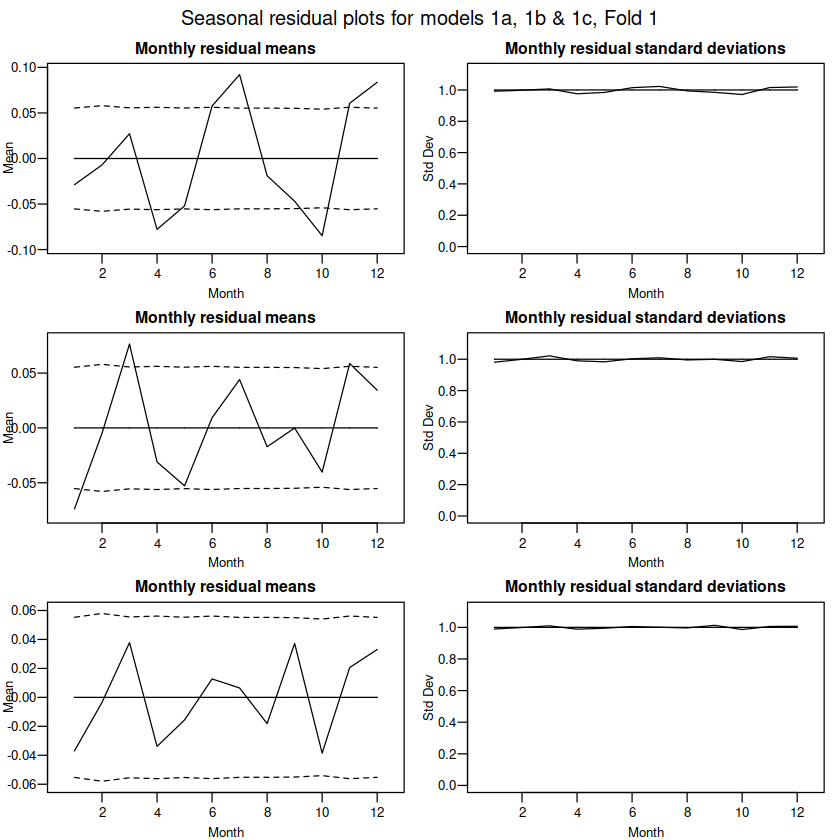

Fitting to data excluding years 1991 to 1996 ...


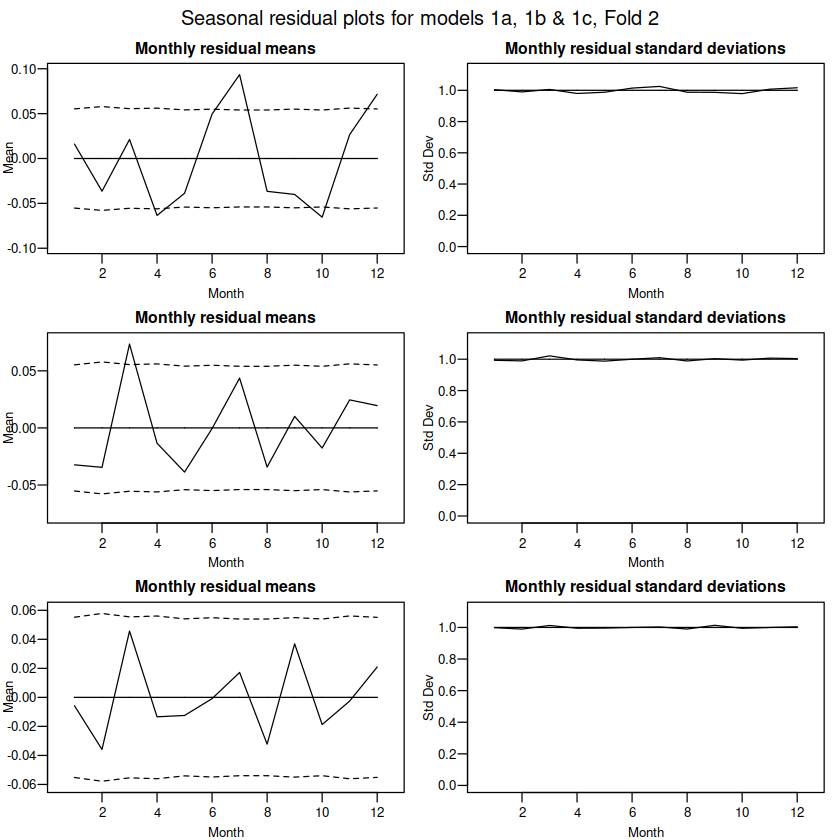

Fitting to data excluding years 1997 to 2002 ...


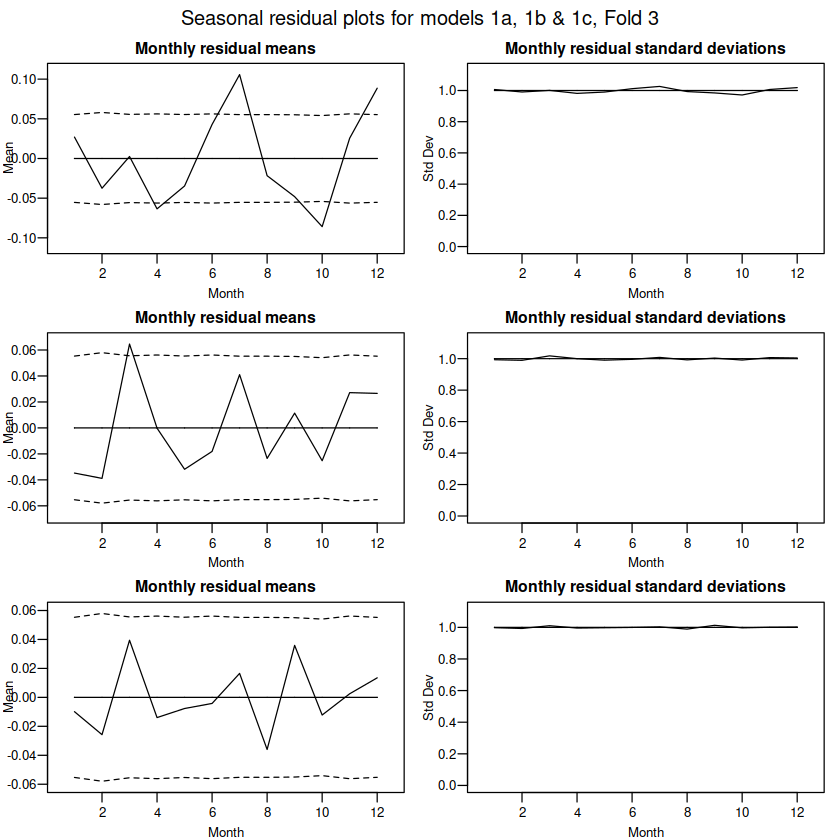

Fitting to data excluding years 2003 to 2008 ...


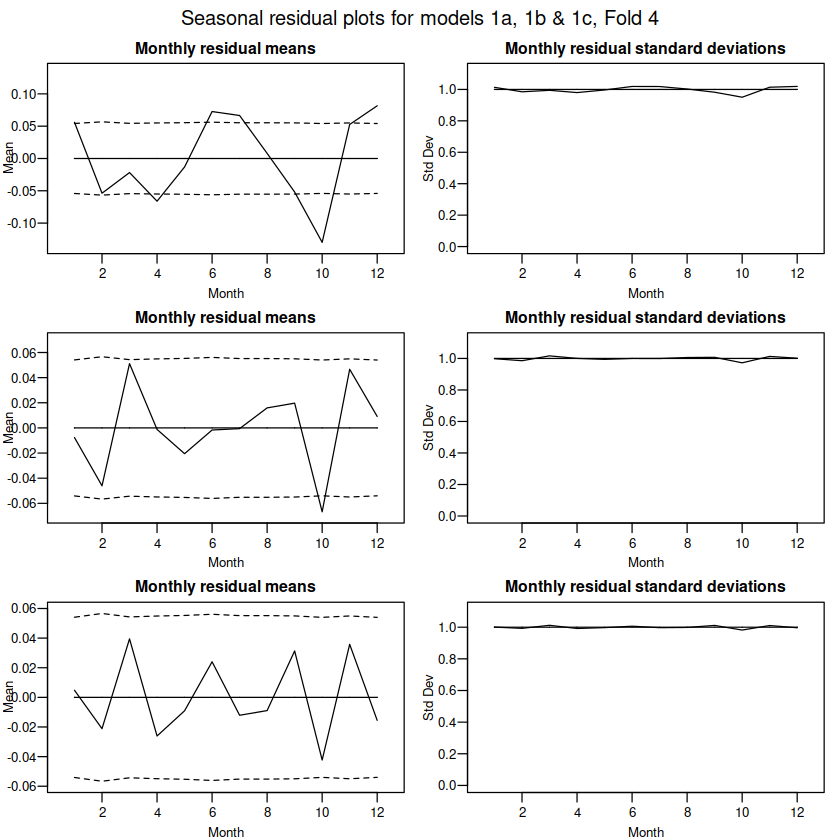

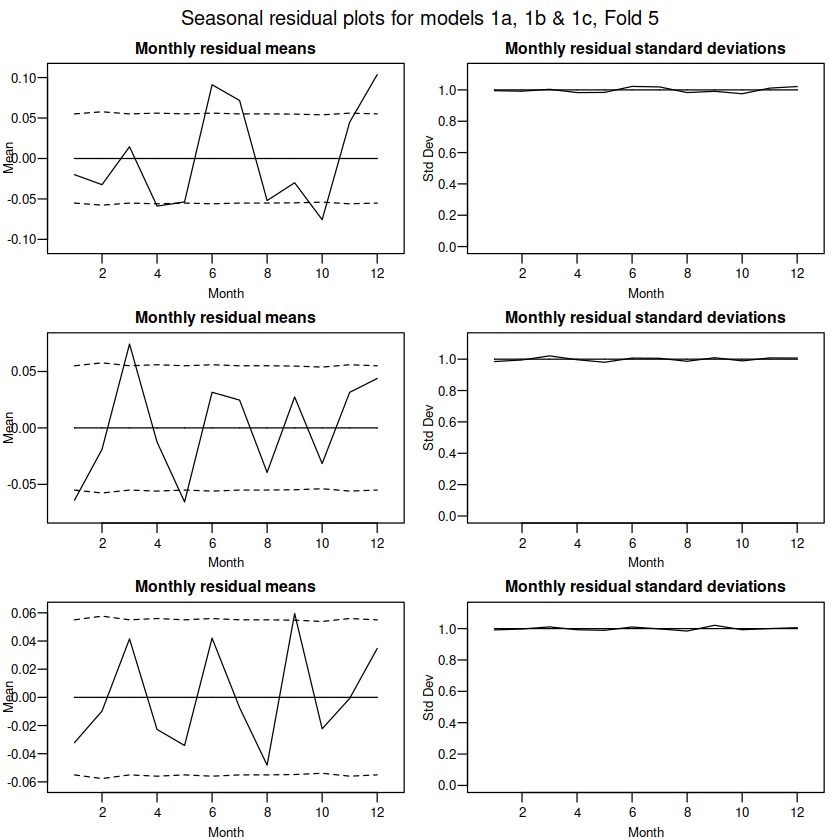

In [5]:
for (Fold in 1:NFolds) {
  YearsToExclude <- Folds$First[Fold]:Folds$Last[Fold]
  cat(paste("Fitting to data excluding years",min(YearsToExclude),"to",
            max(YearsToExclude),"...\n"))
  write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
                file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
  par(mfrow=c(3,2), mar=c(3,3,2,1), mgp=c(2,0.75,0), oma=c(0,0,2,0))
  for (ID in letters[1:3]) {
    assign(paste("Model1",ID,sep=""),
           GLCfit(get(paste("Model1",ID,".Init",sep="")),
                  data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
                  model.type="logistic", diagnostics=1, nprev.required=-1,
                  verbosity=0))
    plot(get(paste("Model1",ID,sep="")), which.plots=1)
  }
  mtext(paste("Seasonal residual plots for models 1a, 1b & 1c, Fold",Fold),
        outer=TRUE, line=0.25)
  #
  #   Store the chosen model in the list
  #
  FittedModels[[Fold]] <- list(Model1=Model1c)
}


## Model 2: initial regional variation

For each fold, draw a map of the residuals at each site. Also plot residuals against each of the available site attributes.


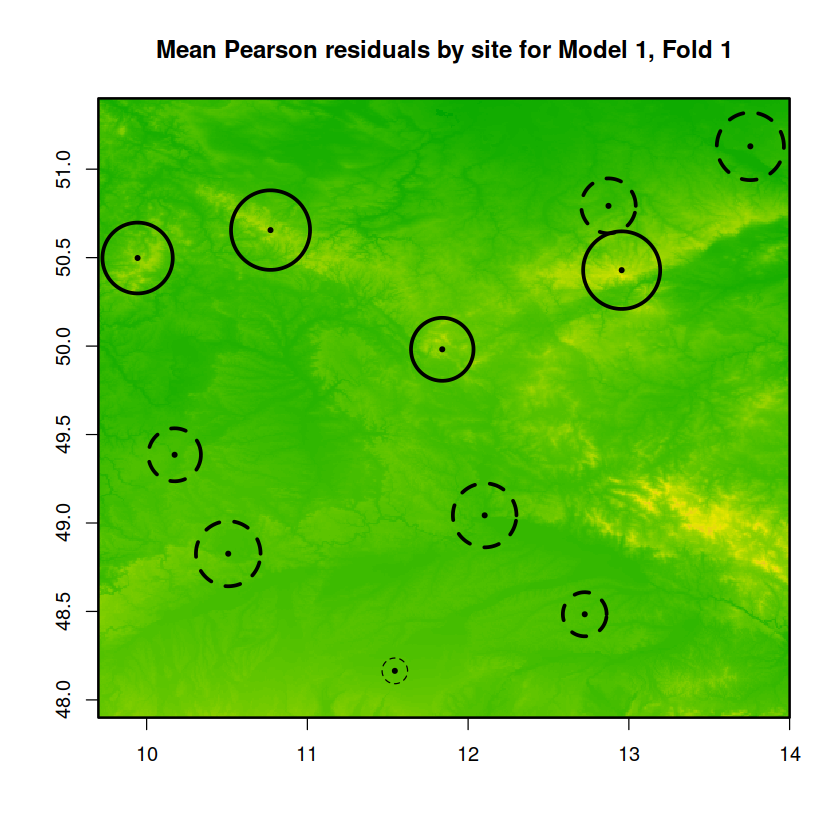

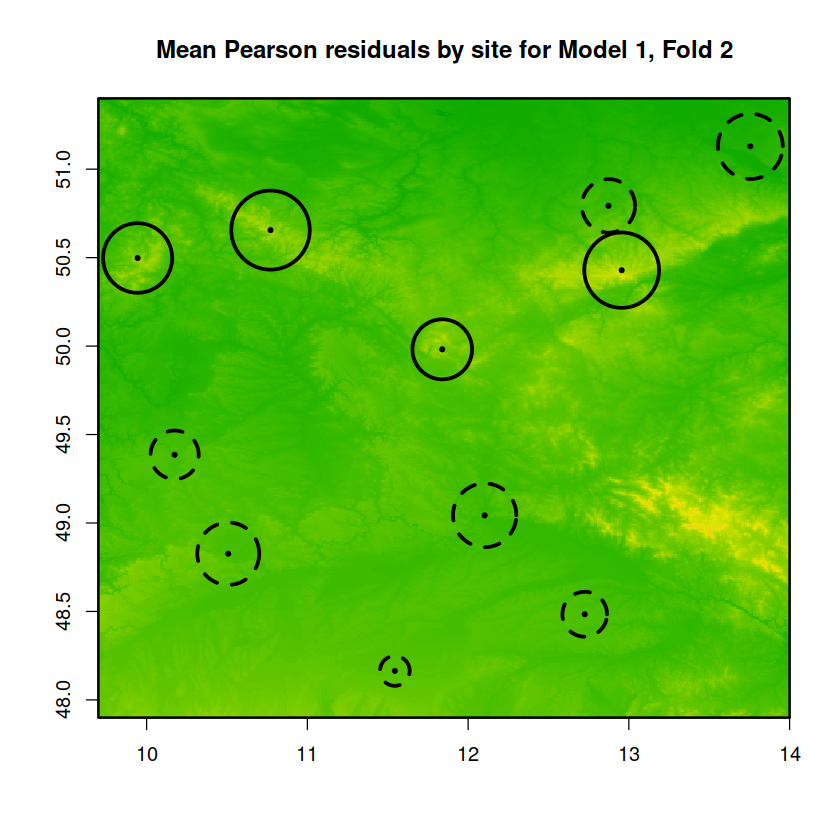

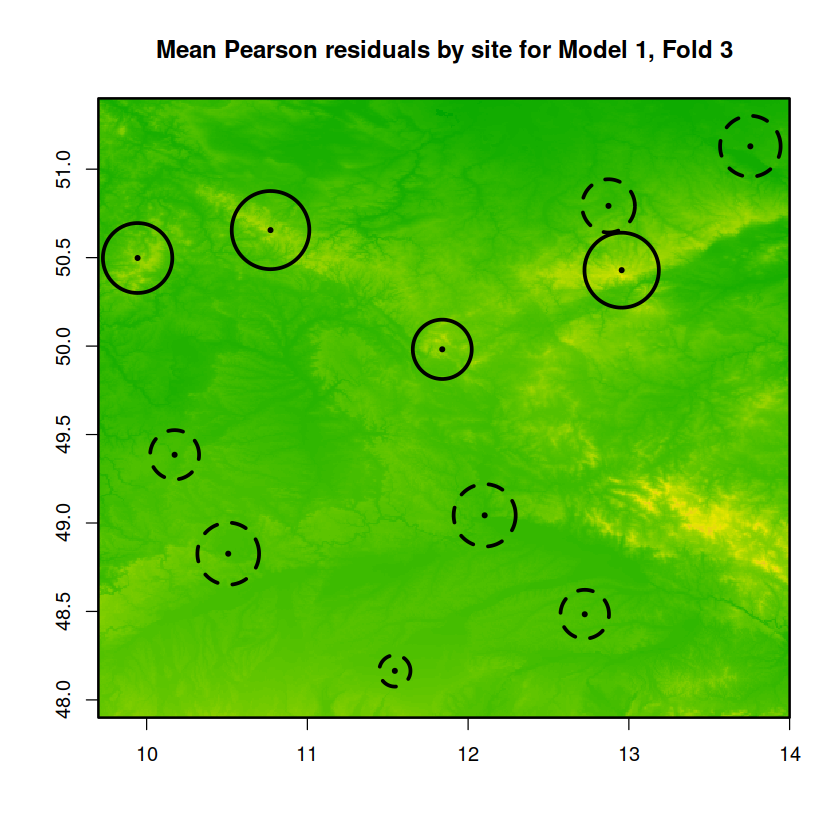

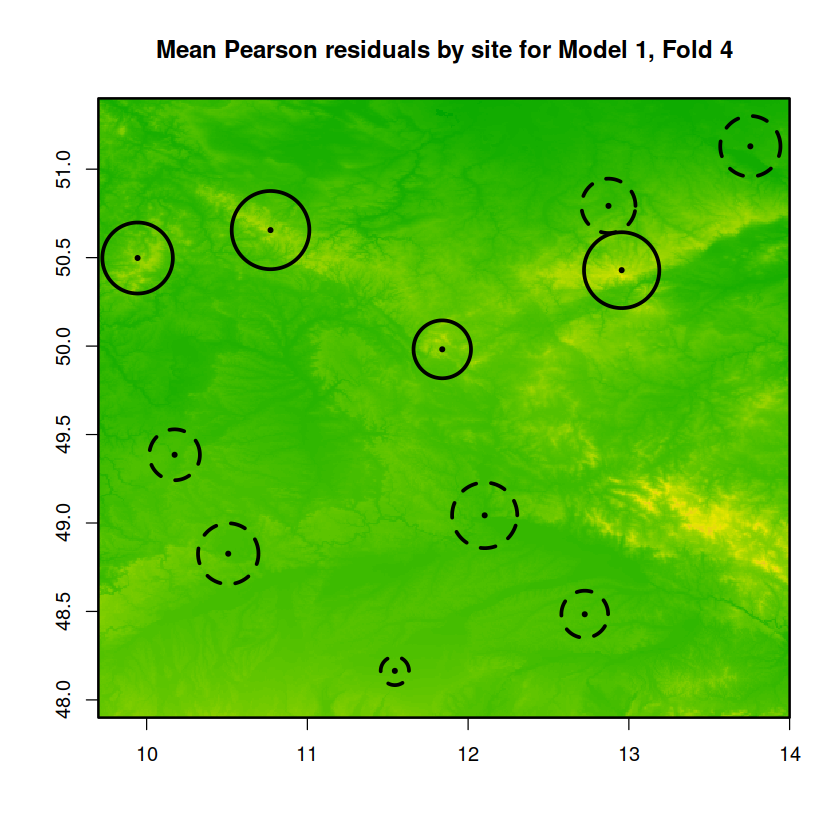

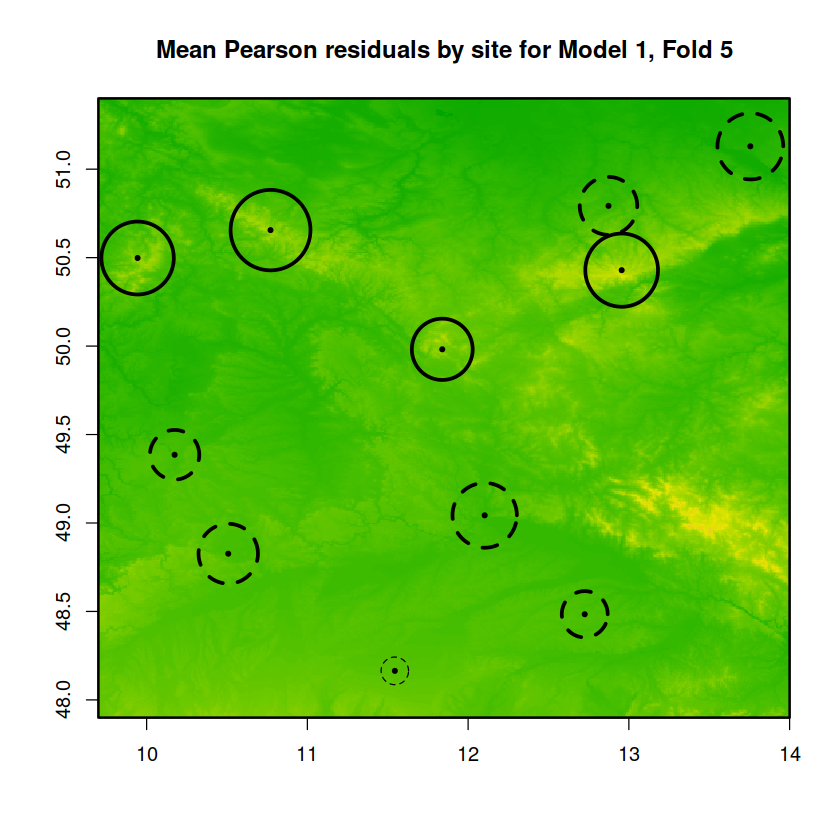

In [6]:
for (Fold in 1:NFolds) {
  par(mfrow=c(1,1), oma=c(0,0,0,0), ask=TRUE)
  DrawMap(LongLims,LatLims)
  plot(FittedModels[[Fold]]$Model1,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=3),
     title=FALSE)
  title(paste("Mean Pearson residuals by site for Model 1, Fold", Fold))
}


That actually looks as though the positive residuals are those in or near higher-elevation areas, so possibly altitude will be the dominant regional predictor rather than some representation of latitude andlongitude effects. Let's look:


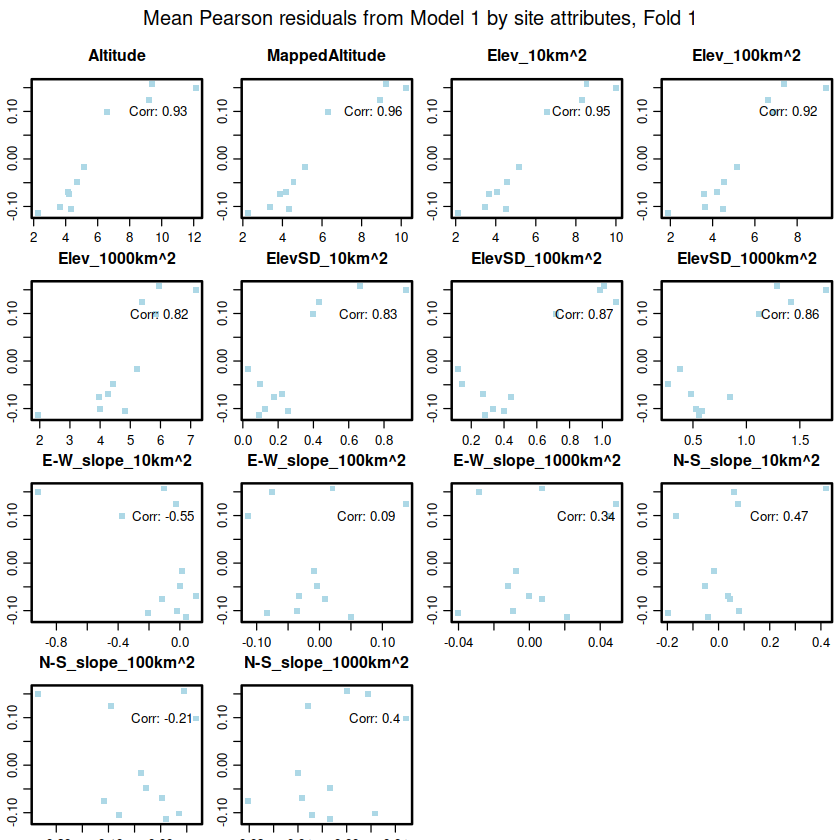

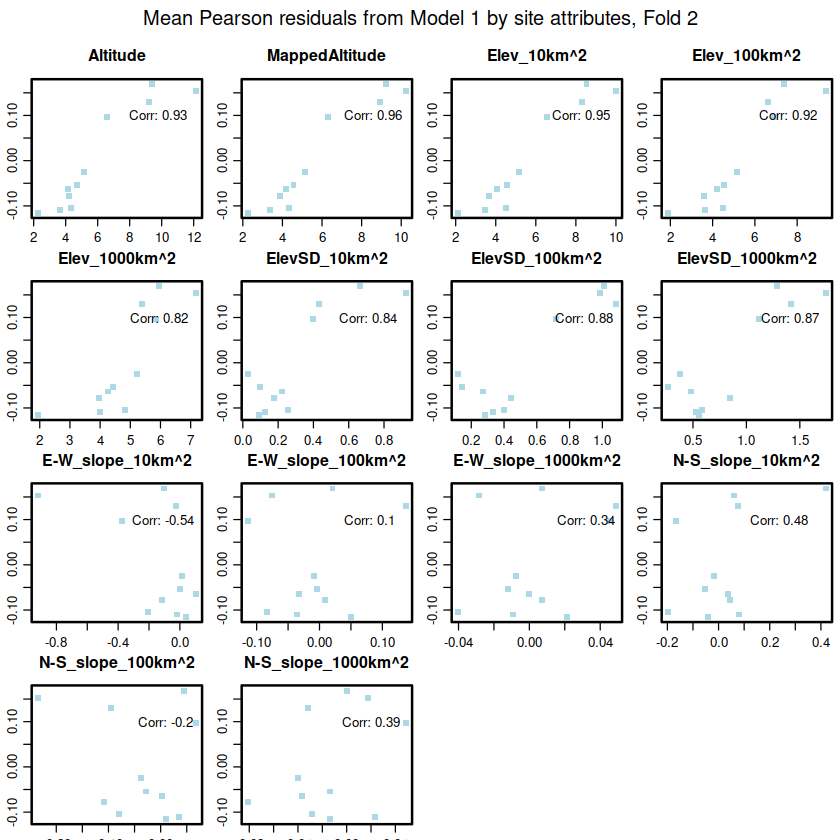

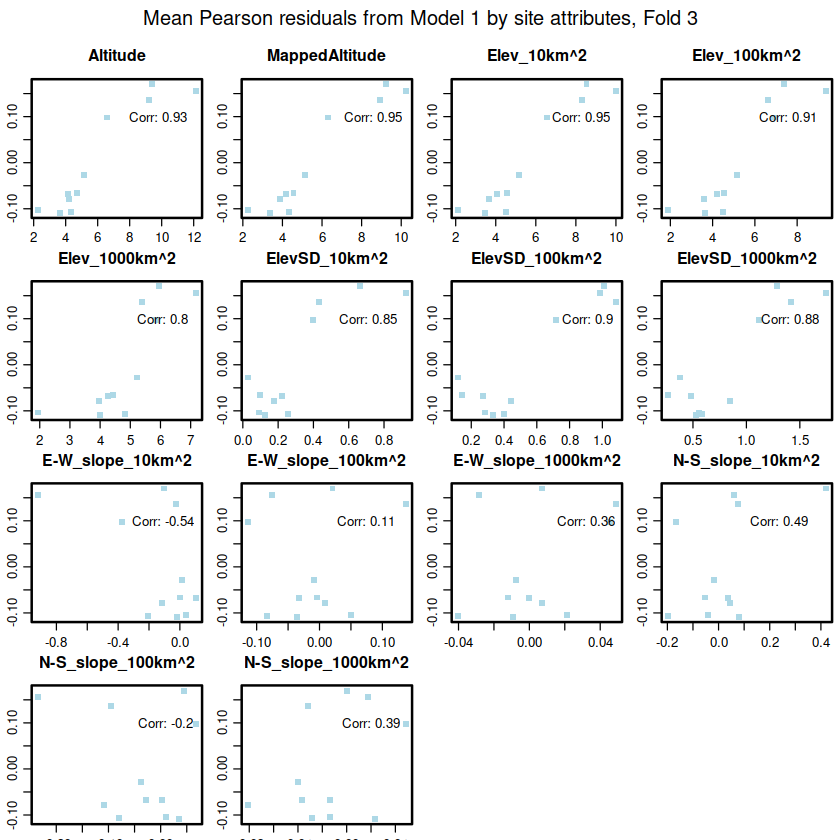

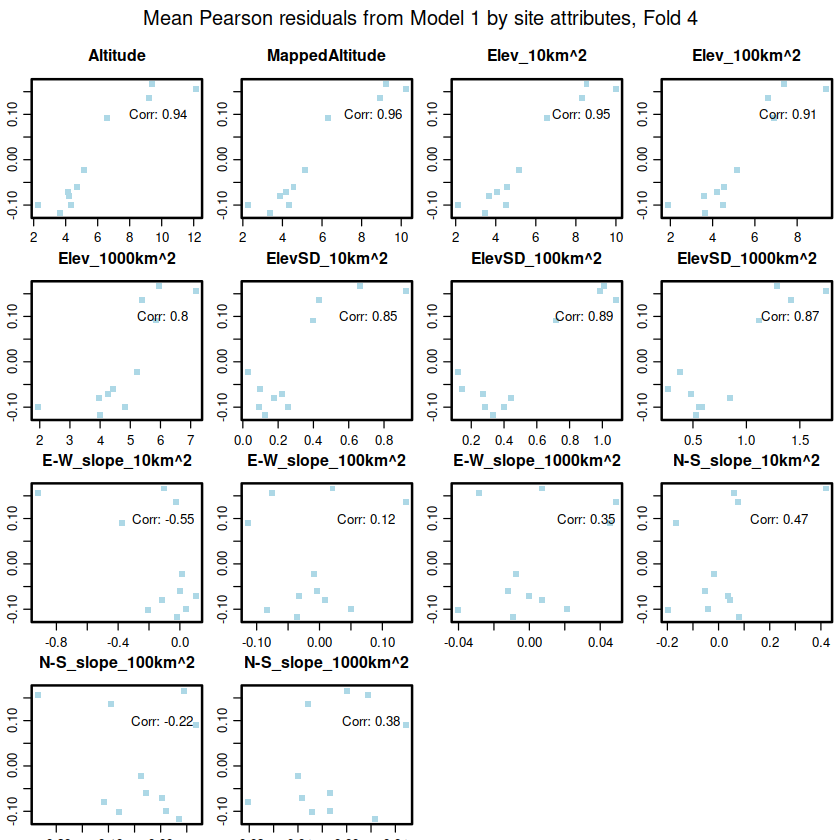

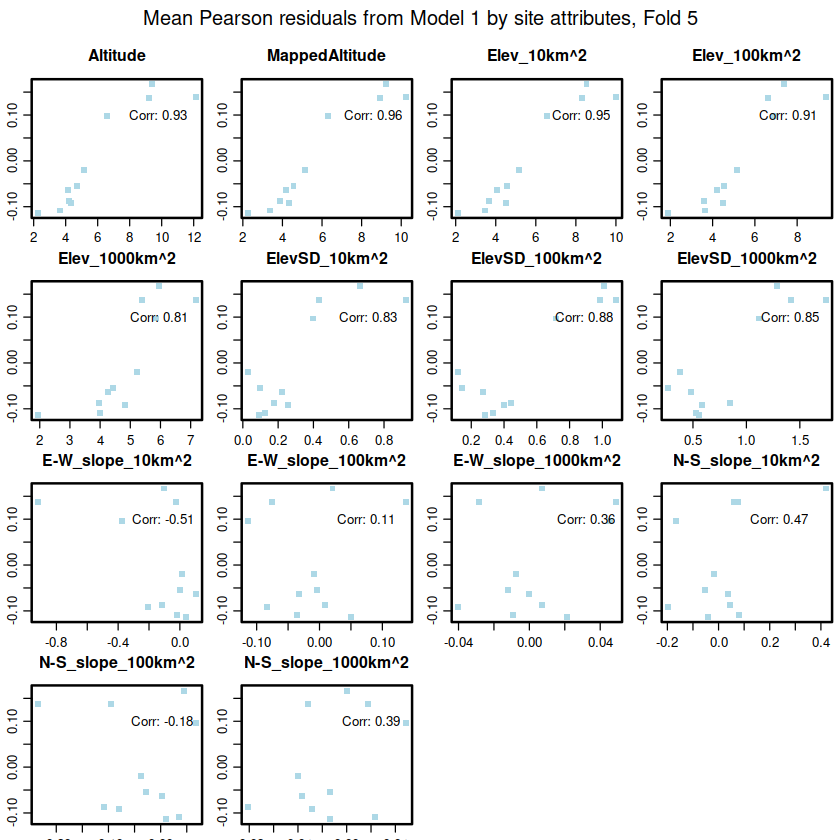

In [7]:
for (Fold in 1:NFolds) {
  par(mfrow=c(4,4), mar=c(1,2,3,0.5), mgp=c(2,0.75,0), lwd=2, 
      oma=c(0,0,2,0), ask=TRUE)
  site.resids <- FittedModels[[Fold]]$Model1$Residuals$Pearson$Site.table$Mean
  sites.wanted <- !is.na(site.resids)
  for (i in 3:16) {
  tmp <- stations$Attribute.values[,i]
  plot(tmp[sites.wanted],site.resids[sites.wanted],xlab="",ylab="",
       pch=15,col="lightblue",main=stations$Attribute.names[i])
  text(quantile(tmp[sites.wanted],0.98,na.rm=TRUE),0.1,adj=1,
       paste("Corr:",round(cor(tmp,site.resids,use="complete.obs"),2)))
  }
  mtext(paste("Mean Pearson residuals from Model 1 by site attributes, Fold",
              Fold), outer=TRUE, line=0.25)
}


OK: it's altitude every time. The highest correlations (typically about 0.96) are between the residuals and _mapped_ altitude. The size of the correlation suggests that mapped altitude explains almost all of the variation in means residuals, which is quite nice. So for this initial representation of regional variation, just add mapped altitude to the model for every fold.

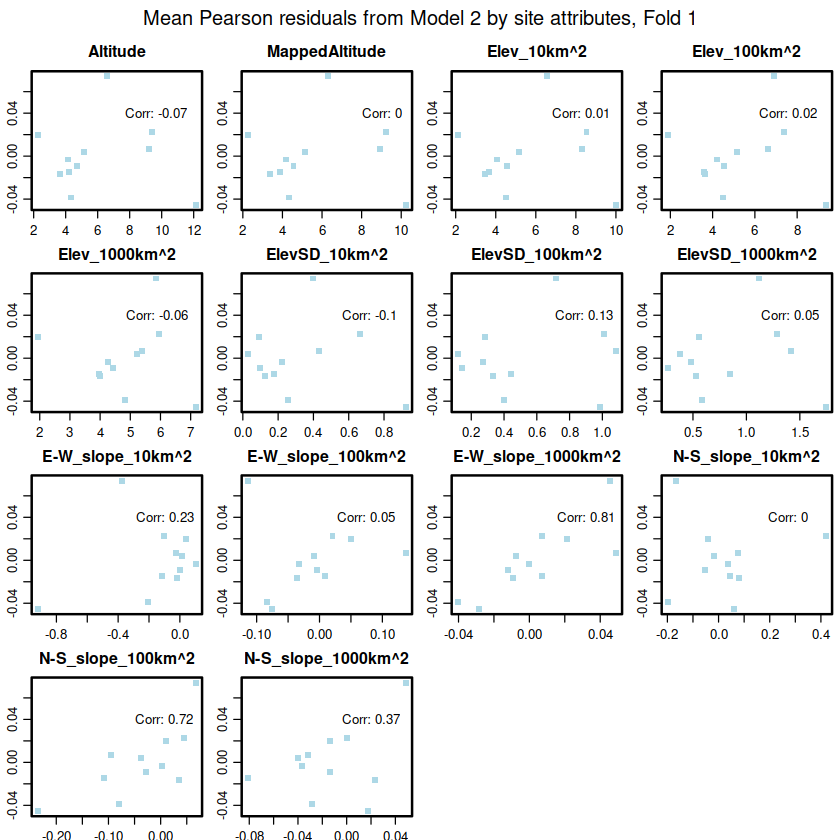

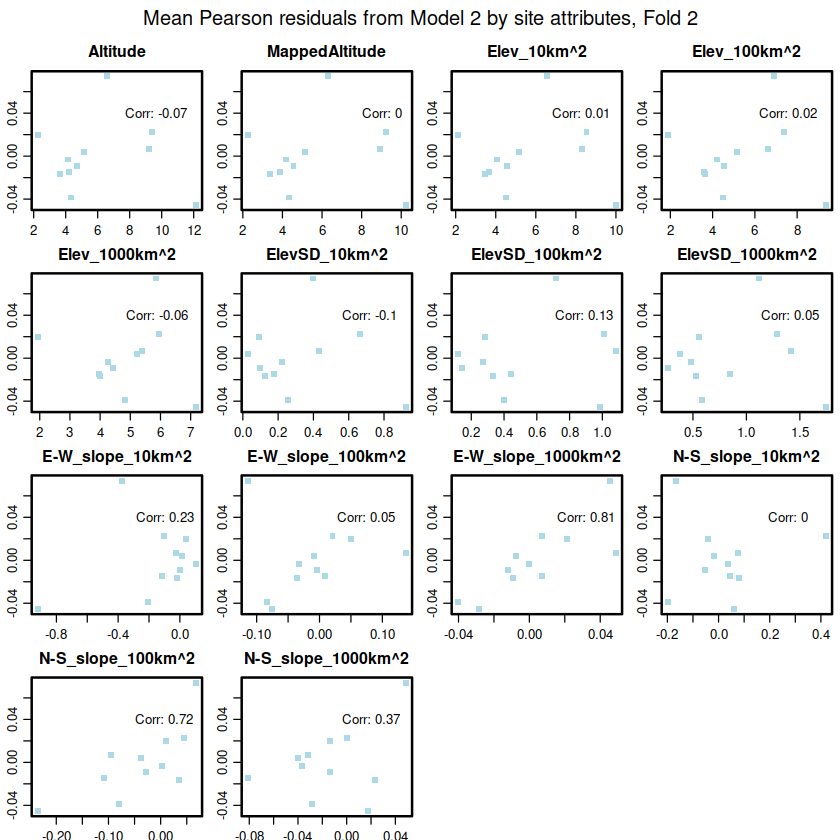

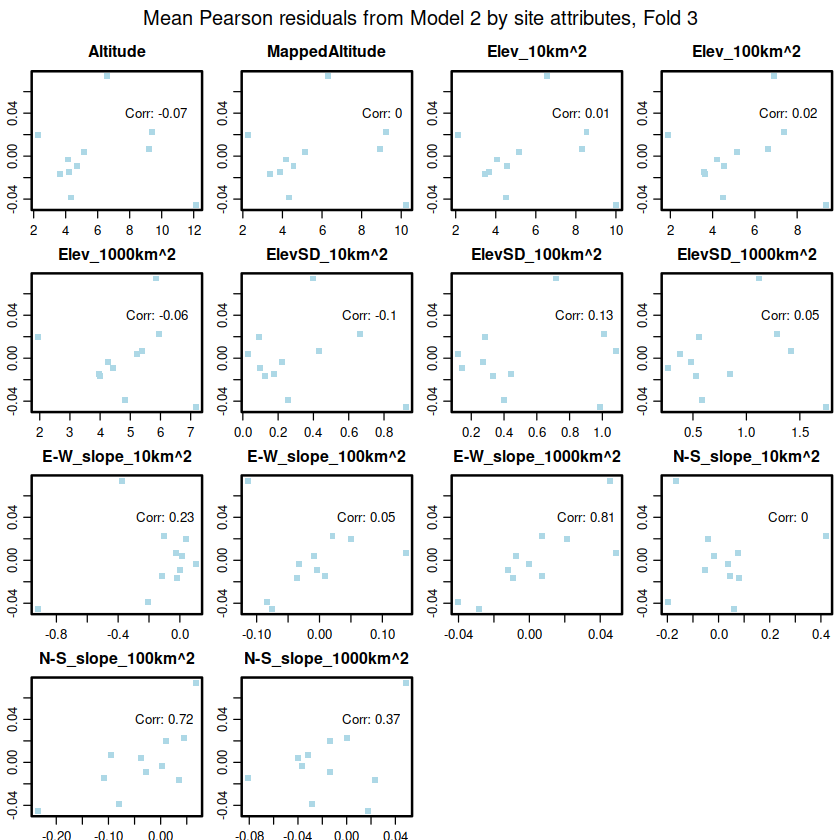

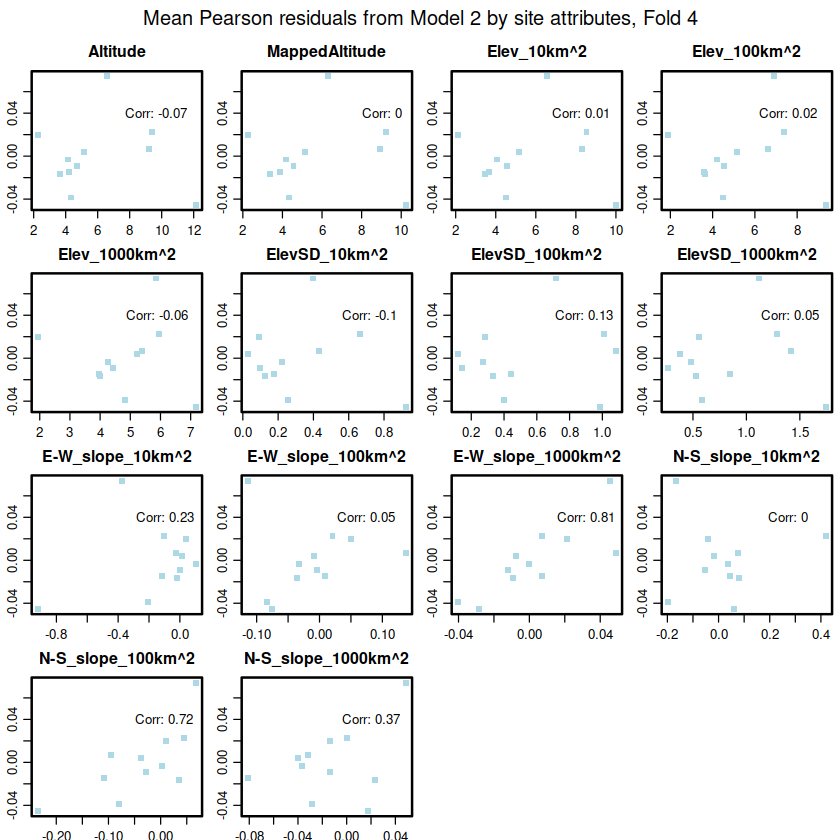

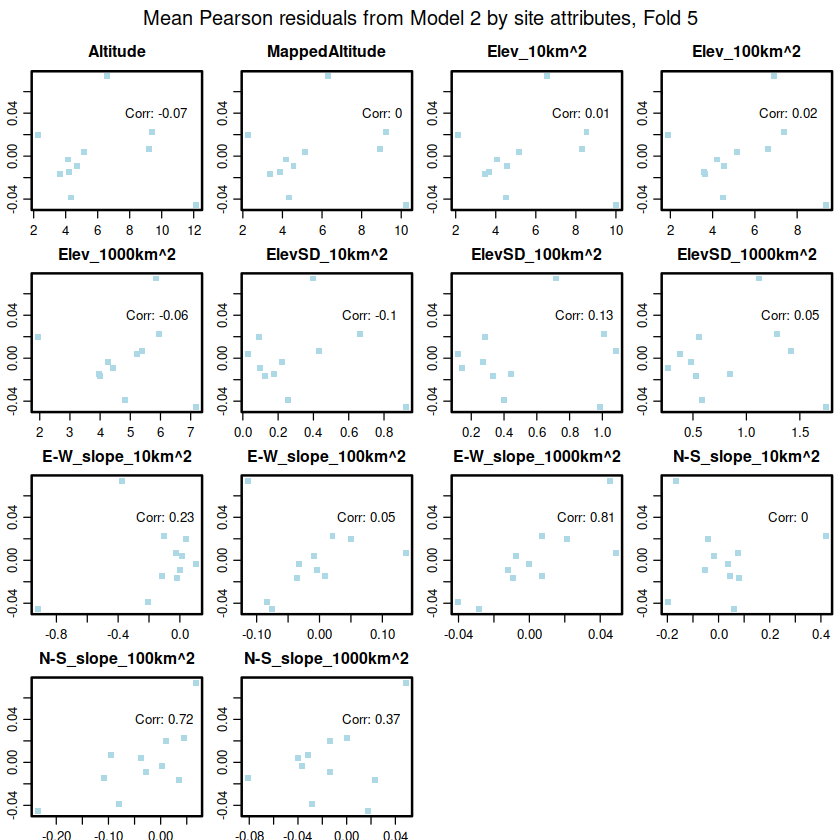

In [8]:
#
#   Next line: use one of the previous fits as initialisation (need to edit
#   the definition file to ad altitude before subsequently reading it)
#
if (!file.exists("Rglimclim_files/DEFINITIONS/Model2Init.def")) {
  write.modeldef(FittedModels$Fold1$Model1, file="Rglimclim_files/DEFINITIONS/Model2Init.def")
}
Model2.Init <- read.modeldef("Rglimclim_files/DEFINITIONS/Model2Init.def", 
                             model.type = "logistic", siteinfo=stations,
                             var.names = "Precip")
for (Fold in 1:NFolds) {
  FittedModels[[Fold]]$Model2 <- 
    GLCfit(Model2.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
           model.type="logistic", diagnostics=1, nprev.required=-1,
           verbosity=0)
  site.resids <- FittedModels[[Fold]]$Model2$Residuals$Pearson$Site.table$Mean
  sites.wanted <- !is.na(site.resids)
  par(mfrow=c(4,4), mar=c(1.5,2,2.5,0.5), mgp=c(2,0.75,0), lwd=2, 
      oma=c(0,0,2,0), ask=TRUE)
  for (i in 3:16) {
    tmp <- stations$Attribute.values[,i]
    plot(tmp[sites.wanted],site.resids[sites.wanted],xlab="",ylab="",
         pch=15,col="lightblue",main=stations$Attribute.names[i])
    text(quantile(tmp[sites.wanted],0.98,na.rm=TRUE),0.04,adj=1,
         paste("Corr:",round(cor(tmp,site.resids,use="complete.obs"),2)))
  }
  mtext(paste("Mean Pearson residuals from Model 2 by site attributes, Fold",
              Fold), outer=TRUE, line=0.25)
}


This reveals that the $1000km^2$ E-W slope and $100km^2$ N-S slopes are also associated with the mean residuals for all folds: it's worth adding these to the models, therefore. That will be three site effects in total, which is probably enough at this stage. 

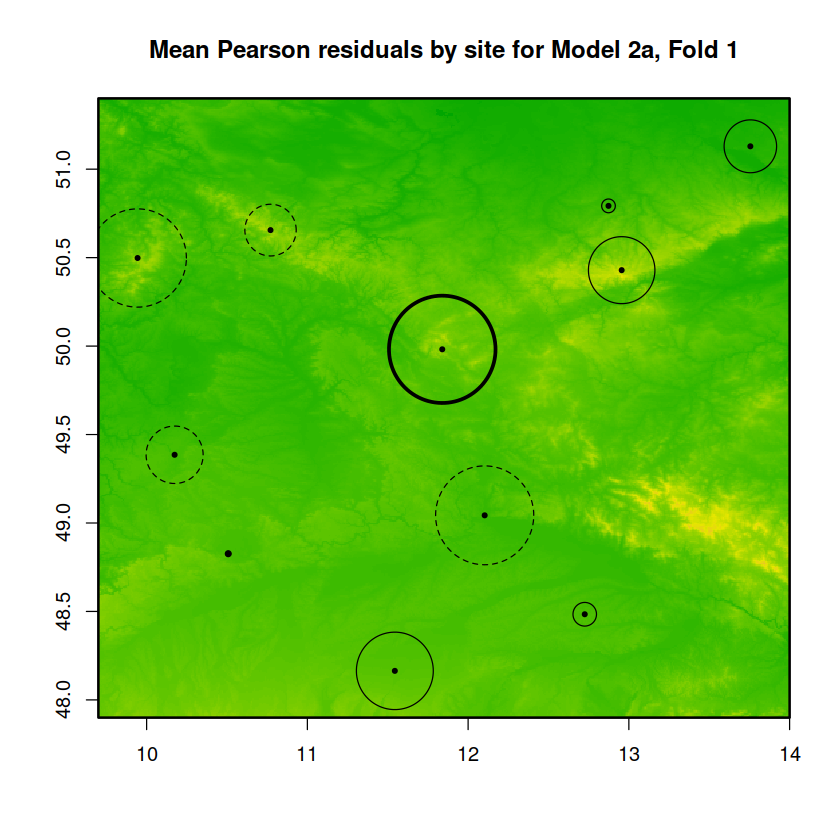

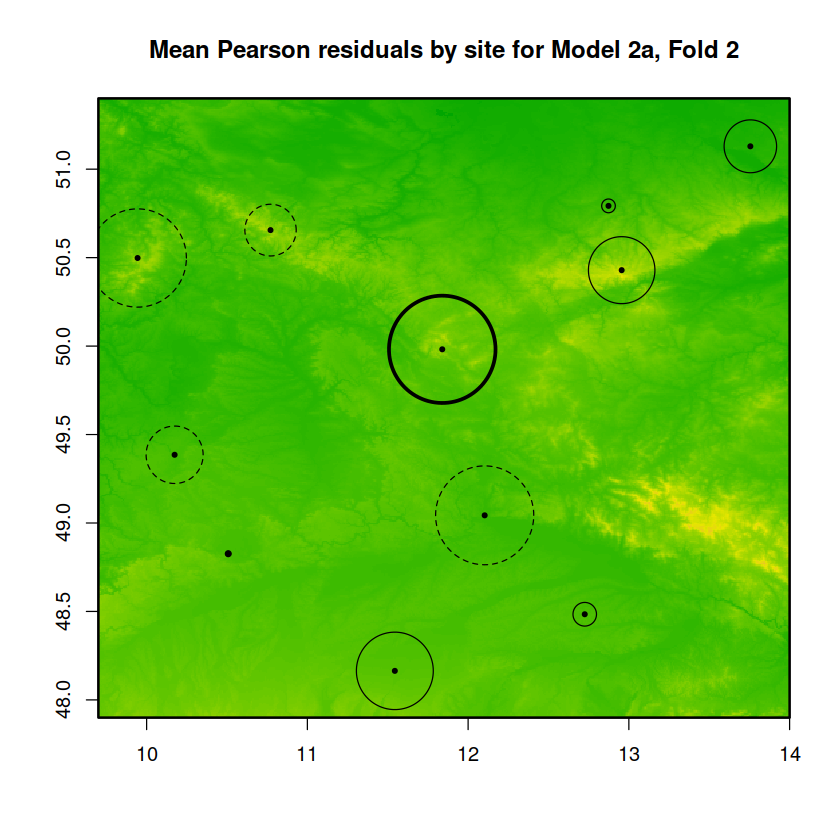

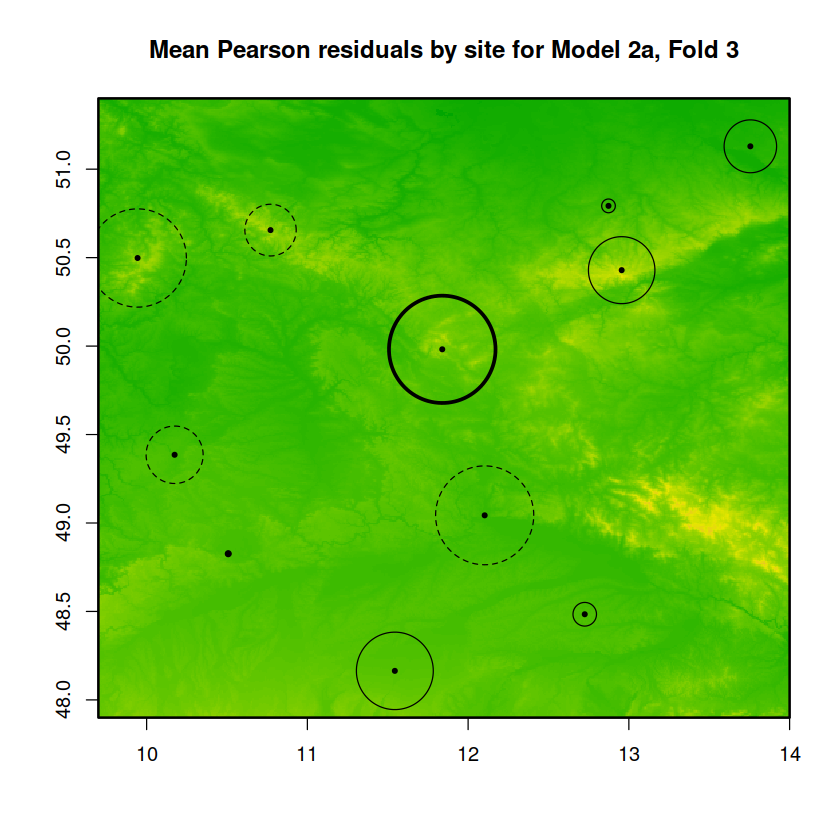

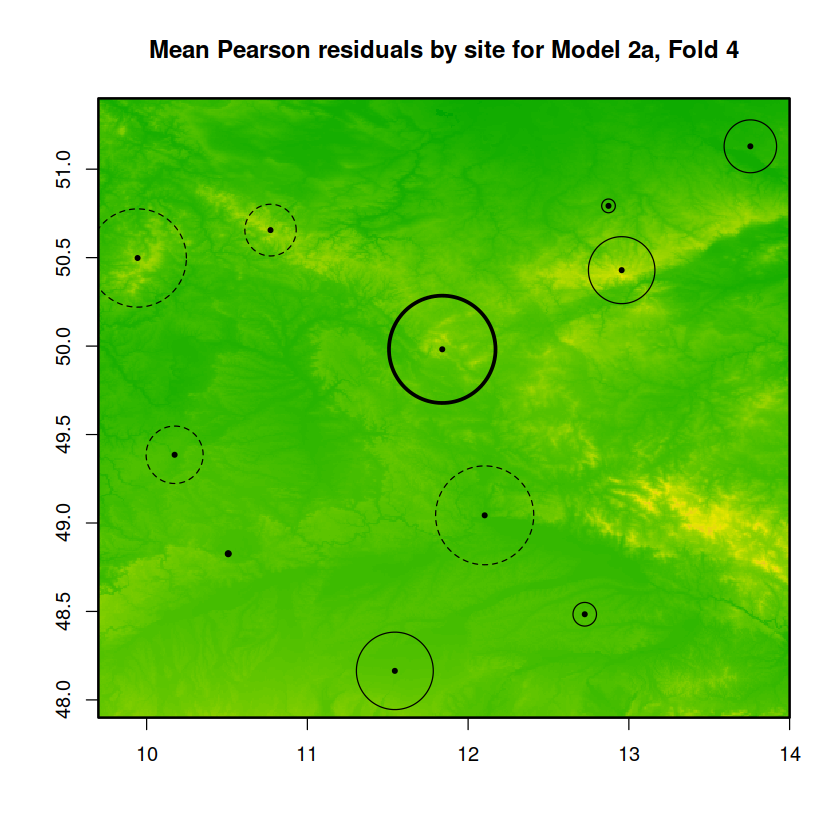

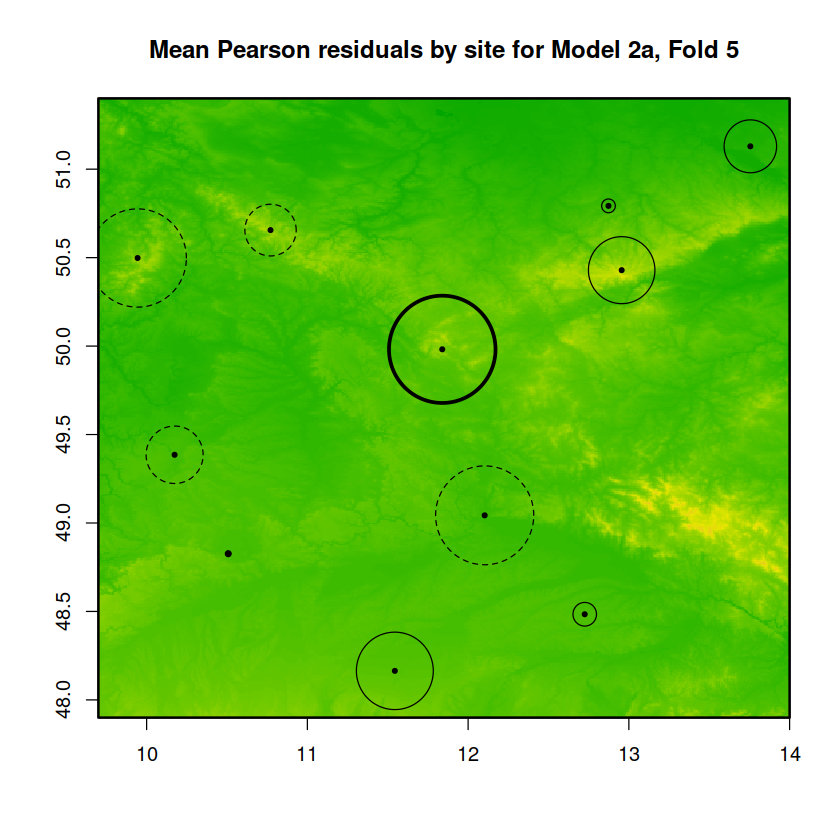

In [9]:
#
#   Next line: use one of the previous fits as initialisation (need to edit
#   the definition file to add altitude before subsequently reading it)
#
if (!file.exists("Rglimclim_files/DEFINITIONS/Model2aInit.def")) {
  write.modeldef(FittedModels$Fold1$Model2, file="Rglimclim_files/DEFINITIONS/Model2aInit.def")
}
Model2a.Init <- read.modeldef("Rglimclim_files/DEFINITIONS/Model2aInit.def", 
                             model.type = "logistic", siteinfo=stations,
                             var.names = "Precip")
for (Fold in 1:NFolds) {
  FittedModels[[Fold]]$Model2a <- 
    GLCfit(Model2a.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
           model.type="logistic", diagnostics=1, nprev.required=-1,
           verbosity=0)
  site.resids <- FittedModels[[Fold]]$Model2a$Residuals$Pearson$Site.table$Mean
  sites.wanted <- !is.na(site.resids)
  par(mfrow=c(1,1), oma=c(0,0,0,0), ask=TRUE)
  DrawMap(LongLims,LatLims)
  plot(FittedModels[[Fold]]$Model2a,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=1),
     title=FALSE)
  title(paste("Mean Pearson residuals by site for Model 2a, Fold", Fold))
}


That looks pretty good: for all five folds, only one of the 11 sites has a mean residual that is (notionally) significantly different from zero, which is unprecedented in occurrence modelling. There's no point doing any formal model comparisons yet, because they will be incorrect until temporal autocorrelation has been accounted for. 

## Model 3: temporal dependence

Start by fitting eight models to each fold: the first four involving just lagged occurrences at each site individually and the second four involving the proportions of wet sites on each of the previous four days. The choice between these will be based on spatially-adjusted likelihood ratios and on the significance of individual terms: to ensure that the $p$-values are correct, define an arbitrary spatial dependence structure (this is needed to ensure that `Rglimclim` implements the required adjustments for inter-site dependence).

To start with, write a model definition file based on Model 2a from one of the folds; this is copied and edited offline to create the eight files needed to initialise fits for each of the candidate models considered here. 

In [10]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model3-1aInit.def")) {
  write.modeldef(FittedModels$Fold1$Model2a,
                 file="Rglimclim_files/DEFINITIONS/Model3-1aInit.def")
}
#
#   Copied and edited offline ... now read the model specs back in
#
for (i in 1:4) {
  for (ID in letters[1:2]) {
  assign(paste("Model3_",i,ID,".Init", sep=""),
         read.modeldef(paste("Rglimclim_files/DEFINITIONS/Model3-",i,ID,"Init.def",sep=""), 
                              model.type = "logistic", siteinfo=stations,
                              var.names = "Precip"))
    }
}

Now loop over the folds. Fit all four models of each type; at each stage, output the fitted model and then do an ANOVA. 


In [11]:
for (Fold in 1:NFolds) {
  YearsToExclude <- Folds$First[Fold]:Folds$Last[Fold]
  cat(paste("Fitting to data excluding years",min(YearsToExclude),"to",
            max(YearsToExclude),"...\n"))
  write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
                file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
  for (ID in letters[1:2]) {
    for (i in 1:4) {
      assign(paste("Model3_",i,ID,sep=""),
           GLCfit(get(paste("Model3_",i,ID,".Init",sep="")),
                  data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
                  model.type="logistic", diagnostics=1, nprev.required=4,
                  verbosity=0))
      print(get(paste("Model3_",i,ID,sep="")))
    }
    #
    #   To compare with Model 2a, need to refit that with nprev.required=4
    #
    tmp <- GLCfit(Model2a.Init, data.file="Rglimclim_files/CurrentData.dat", 
                  siteinfo=stations, model.type="logistic", 
                  diagnostics=0, nprev.required=4, verbosity=0)
    cat("COMPARISON OF MODELS WITH DIFFERENT NUMBERS OF LAGS:\n")
    print(anova(tmp,
                get(paste("Model3_4",ID,sep="")),
                get(paste("Model3_3",ID,sep="")),
                get(paste("Model3_2",ID,sep="")),
                get(paste("Model3_1",ID,sep=""))))
  }
}

Fitting to data excluding years 1979 to 1984 ...
MODEL 3.1A

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.4433   0.0246 -58.7493 < 2.2e-16
1                        MappedAltitude      0.0647   0.0026  24.5556 < 2.2e-16
2                    E-W_slope_1000km^2      1.0482   0.2508   4.1790 2.928e-05
3                     N-S_slope_100km^2      0.2682   0.0784   3.4213 0.0006233
4  Daily annual cycle, cosine component      0.0163   0.0238   0.6852 0.4931983
5    Daily annual cycle, sine component      0.0234   0.0242   0.9681 0.3329755
6  First harmonic of daily annual cycle      0.0953   0.0239   3.9951 6.466e-05
7  First harmonic of daily annual cycle     -0.0056   0.0242  -0.2302 0.8179724
8  Second harmonic of daily annual cycl     -0.0480   0.0240  -1.9985 0.0456615
9  Second harmonic of daily annual cycl     -0.0502   0.0241  -2.0856 0.0370157
10 


The results for the different folds are consistent with respect to the preferred model in each case. For the "A" variants, the preferred lag is 3 in all cases (based on $p$-values increasing by an order of magnitude as you go from lag 3 to lag 4 --- they're still formally significant, but this isn't very relevant with such large datasets). For the "B" variants, the preferred lag is 1; moreover, the _worst_ performing "B" variants are better than the best-performing "A" versions. It's worth averaging over the sites for the lagged terms, therefore. Next question: is a weighted average better? Fit the models, and look at the standard error on the decay rate for the exponential weights: if the decay rate doesn't differ significantly from zero, an unweighted average is OK (`Rglimclim` isn't smart enough to recognise that the unweighted model is a special case of the weighted one, so an ANOVA doesn't work in this case).

### Model with weighted average of previous days' occurrence

Since we are no longer considering models with more than one lag, the "B" versions can be refitted.


In [12]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model3-1cInit.def")) {
  write.modeldef(Model3_1b, file="Rglimclim_files/DEFINITIONS/Model3-1cInit.def")
}
Model3_1c.Init <- read.modeldef("Rglimclim_files/DEFINITIONS/Model3-1cInit.def", 
                             model.type = "logistic", siteinfo=stations,
                             var.names = "Precip", oldGlimClim.warning=FALSE)
for (Fold in 1:NFolds) {
  YearsToExclude <- Folds$First[Fold]:Folds$Last[Fold]
  cat(paste("Fitting to data excluding years",min(YearsToExclude),"to",
            max(YearsToExclude),"...\n"))
  write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
                file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
  FittedModels[[Fold]]$Model3_1b <- 
    GLCfit(Model3_1b.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
           model.type="logistic", diagnostics=1, nprev.required=1,
           verbosity=0)
  FittedModels[[Fold]]$Model3_1c <- 
    GLCfit(Model3_1c.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
           model.type="logistic", diagnostics=1, nprev.required=1,
           verbosity=0)
  print(FittedModels[[Fold]]$Model3_1c)
  cat("\nIndependence log-likelihoods for fitted models 3.1B and 3.1C:\n")
  cat("3.1B: "); print(logLik(FittedModels[[Fold]]$Model3_1b))
  cat("3.1C: "); print(logLik(FittedModels[[Fold]]$Model3_1c))
}

Fitting to data excluding years 1979 to 1984 ...
MODEL 3.1C

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.9092   0.0318 -60.0913 < 2.2e-16
1                        MappedAltitude      0.0919   0.0027  34.3000 < 2.2e-16
2                    E-W_slope_1000km^2      1.3032   0.2552   5.1068 3.277e-07
3                     N-S_slope_100km^2      0.3805   0.0792   4.8035 1.559e-06
4  Daily annual cycle, cosine component      0.0097   0.0244   0.3962   0.69194
5    Daily annual cycle, sine component      0.0184   0.0248   0.7398   0.45943
6  First harmonic of daily annual cycle      0.0743   0.0244   3.0459   0.00232
7  First harmonic of daily annual cycle     -0.0041   0.0249  -0.1655   0.86852
8  Second harmonic of daily annual cycl     -0.0378   0.0245  -1.5423   0.12301
9  Second harmonic of daily annual cycl     -0.0391   0.0247  -1.5796   0.11420
10 


In all cases, the estimated decay parameters are significantly different from zero; and the independence log-likelihoods from the "C" versions exceed those from the "B" versions by about 150. Although the log-likelihood comparison doesn't account for the inter-site dependence, it's a big increase for a single additional parameter. By this stage therefore, the "3C" models are preferred for all folds. 



## Final baseline model

Here we need to consider interactions. The initial strategy is to add seasonal:regional, seasonal:lag-1 and regional:lag-1 interactions to Model 3c for each fold. Then look at the significance of the individual terms to identify what can potentially be dropped. For the seasonal interactions, only consider the annual cycle rather than the harmonics (this is based partly on experience with other datasets).

In [13]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model4aInit.def")) {
  write.modeldef(FittedModels$Fold1$Model3_1c,
                 file="Rglimclim_files/DEFINITIONS/Model4aInit.def")
}
Model4a.Init <- read.modeldef("Rglimclim_files/DEFINITIONS/Model4aInit.def", 
                             model.type = "logistic", siteinfo=stations,
                             var.names = "Precip", oldGlimClim.warning=FALSE)
for (Fold in 1:NFolds) {
  YearsToExclude <- Folds$First[Fold]:Folds$Last[Fold]
  cat(paste("Fitting to data excluding years",min(YearsToExclude),"to",
            max(YearsToExclude),"...\n"))
  write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
                file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
  FittedModels[[Fold]]$Model4a <- 
    GLCfit(Model4a.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
           model.type="logistic", diagnostics=1, nprev.required=1,
           verbosity=0)
  print(FittedModels[[Fold]]$Model4a)
}

Fitting to data excluding years 1979 to 1984 ...
MODEL 4A

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.8086   0.0348 -52.0383 < 2.2e-16
1                        MappedAltitude      0.0731   0.0038  19.2450 < 2.2e-16
2                    E-W_slope_1000km^2      1.3940   0.3641   3.8283  0.000129
3                     N-S_slope_100km^2      0.2327   0.1120   2.0779  0.037715
4  Daily annual cycle, cosine component     -0.4079   0.0439  -9.2944 < 2.2e-16
5    Daily annual cycle, sine component     -0.0941   0.0431  -2.1821  0.029101
6  First harmonic of daily annual cycle      0.0750   0.0246   3.0531  0.002265
7  First harmonic of daily annual cycle     -0.0045   0.0250  -0.1814  0.856042
8  Second harmonic of daily annual cycl     -0.0399   0.0247  -1.6181  0.105634
9  Second harmonic of daily annual cycl     -0.0366   0.0248  -1.4725  0.140878
10 Di


For all folds, the interaction between E-W slope and the "lag 1" term is insignificant and that between N-S slope and the "lag 1" term is a bit borderline --- for folds 2 and 3 the $p$-values are 0.02 and 0.03 respectively, but in both cases I would exclude them from a model in normal circumstances because (a) the sample size is so large that this kind of $p$-value indicates something of very little practical relevance (b) "slope" is a two-dimensional concept so that if you include the N-S slope covariate then you should probably include the E-W one as well: this pushes the $p$-value threshold for inclusion down, because you're effectively allowing two degrees of freedom. 

The "slope is two-dimensional" argument is also used to justify the inclusion of the seasonal:N-S interactions for all folds. The $p$-values for these are all larger than those for the corresponding seasonal:E-W interactions; and the largest is 0.02, for Fold 3. Here however, the $p$-value for the corresponding seasonal:E-W interaction is on the order of $10^{-7}$: that interaction is very clearly significant, so one might reasonably judge that the corresponding N-S interaction should also be included. 

On this basis, for all folds there is some justification for removing the lag:slope interactions but retaining everything else. So: fit the slightly pruned model in all cases (the definition file for Model 4b has been produced offline, by deleting rows in the file for Model 4a). Do the ANOVA for comparing models 3.1c, 4a and 4b; and produce residual plots for Model 4b. Looking ahead to the incorporation of external predictors, also fit linear trend models to the annual mean residuals from Model 4b.

Fitting to data excluding years 1979 to 1984 ...
MODEL 4B

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.8154   0.0348 -52.1655 < 2.2e-16
1                        MappedAltitude      0.0753   0.0036  20.6365 < 2.2e-16
2                    E-W_slope_1000km^2      1.3553   0.2582   5.2489 1.530e-07
3                     N-S_slope_100km^2      0.3839   0.0803   4.7783 1.768e-06
4  Daily annual cycle, cosine component     -0.4083   0.0439  -9.2948 < 2.2e-16
5    Daily annual cycle, sine component     -0.0943   0.0432  -2.1849  0.028895
6  First harmonic of daily annual cycle      0.0749   0.0246   3.0518  0.002275
7  First harmonic of daily annual cycle     -0.0045   0.0250  -0.1817  0.855841
8  Second harmonic of daily annual cycl     -0.0399   0.0247  -1.6178  0.105709
9  Second harmonic of daily annual cycl     -0.0366   0.0248  -1.4723  0.140927
10 Di

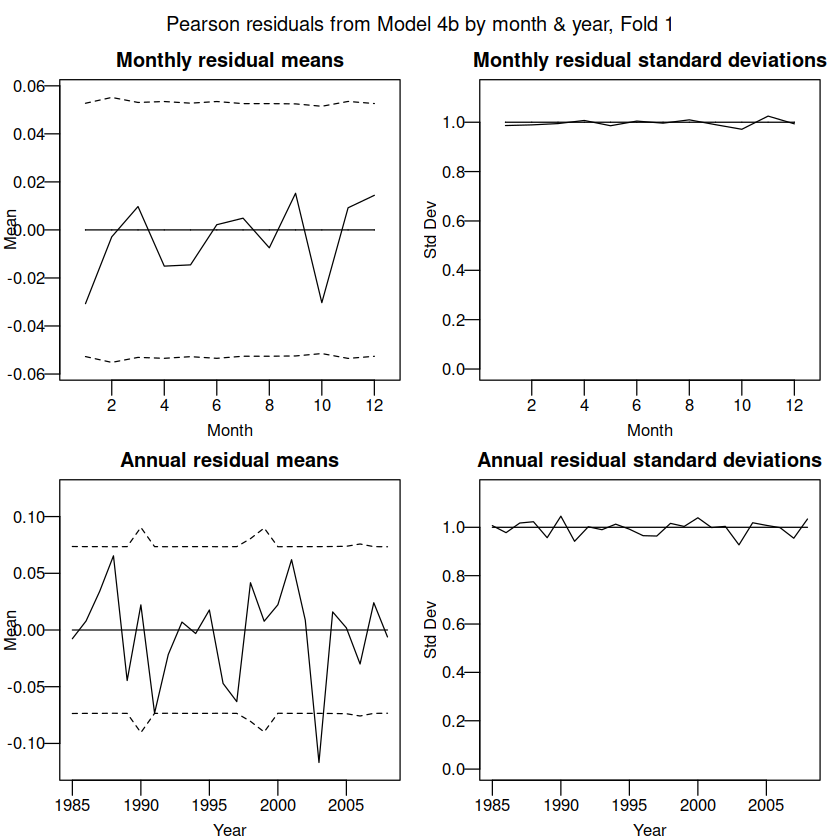

Fitting to data excluding years 1985 to 1990 ...
MODEL 4B

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.8590   0.0348 -53.4505 < 2.2e-16
1                        MappedAltitude      0.0800   0.0037  21.7975 < 2.2e-16
2                    E-W_slope_1000km^2      1.3863   0.2539   5.4596 4.771e-08
3                     N-S_slope_100km^2      0.4100   0.0801   5.1178 3.091e-07
4  Daily annual cycle, cosine component     -0.3593   0.0442  -8.1219 4.591e-16
5    Daily annual cycle, sine component     -0.1102   0.0427  -2.5804  0.009868
6  First harmonic of daily annual cycle      0.0769   0.0246   3.1290  0.001754
7  First harmonic of daily annual cycle     -0.0054   0.0246  -0.2199  0.825947
8  Second harmonic of daily annual cycl     -0.0336   0.0245  -1.3675  0.171463
9  Second harmonic of daily annual cycl     -0.0232   0.0246  -0.9405  0.346973
10 Di

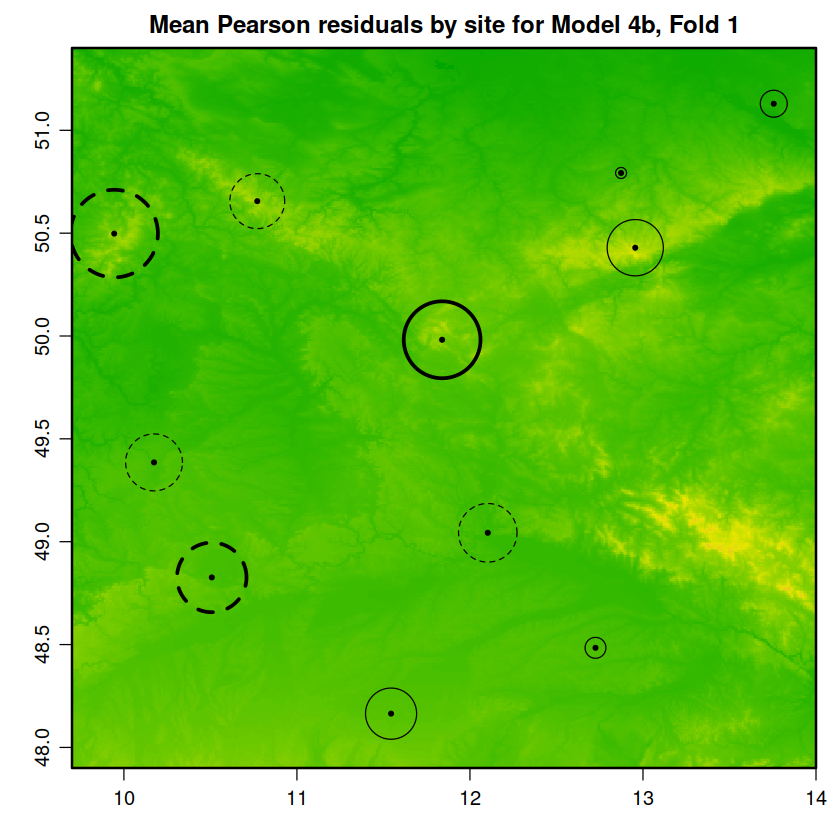


Linear trend model for annual mean residuals from Model 4b:

Call:
lm(formula = MeanRes ~ Year)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.109593 -0.019955  0.007627  0.025884  0.076095 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -3.298e-03  1.033e-02  -0.319    0.753
Year         2.092e-05  1.001e-03   0.021    0.984

Residual standard error: 0.0443 on 22 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  1.986e-05,	Adjusted R-squared:  -0.04543 
F-statistic: 0.0004369 on 1 and 22 DF,  p-value: 0.9835



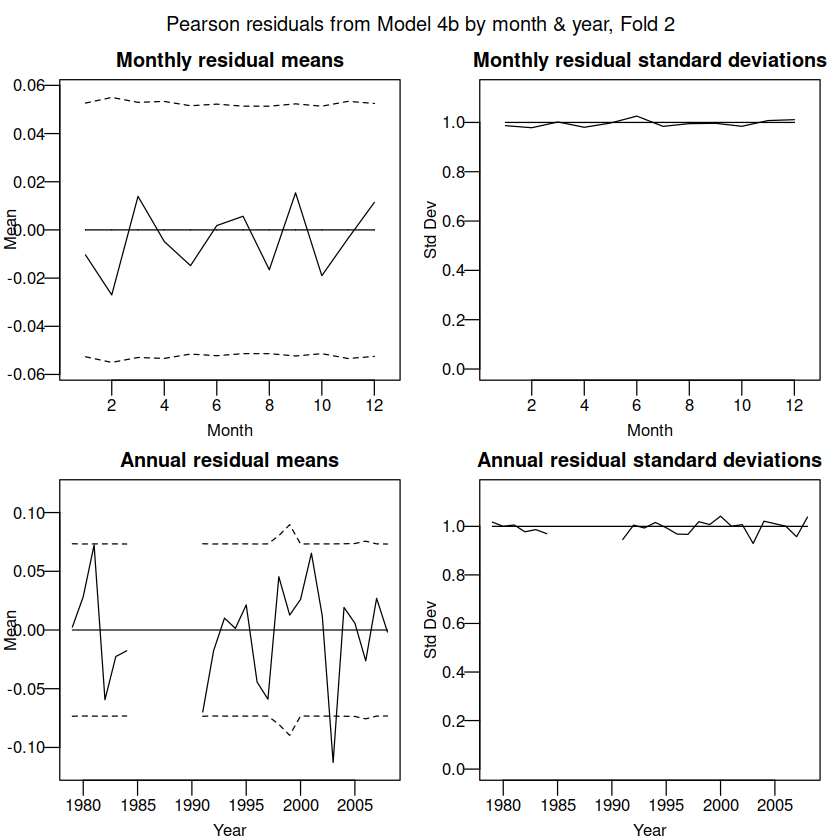

Fitting to data excluding years 1991 to 1996 ...
MODEL 4B

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.8240   0.0350 -52.0709 < 2.2e-16
1                        MappedAltitude      0.0792   0.0037  21.6634 < 2.2e-16
2                    E-W_slope_1000km^2      1.6316   0.2563   6.3654 1.948e-10
3                     N-S_slope_100km^2      0.3693   0.0812   4.5468 5.446e-06
4  Daily annual cycle, cosine component     -0.3723   0.0443  -8.3957 < 2.2e-16
5    Daily annual cycle, sine component     -0.0577   0.0431  -1.3394    0.1804
6  First harmonic of daily annual cycle      0.0986   0.0246   4.0082 6.118e-05
7  First harmonic of daily annual cycle     -0.0005   0.0248  -0.0192    0.9847
8  Second harmonic of daily annual cycl     -0.0183   0.0247  -0.7403    0.4591
9  Second harmonic of daily annual cycl     -0.0372   0.0247  -1.5062    0.1320
10 Di

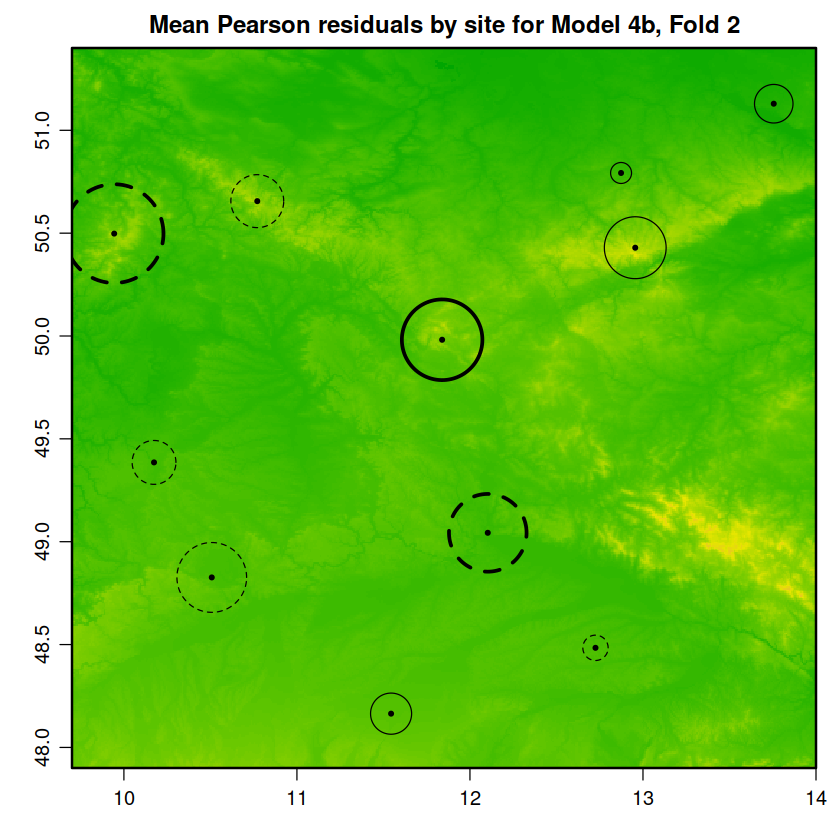


Linear trend model for annual mean residuals from Model 4b:

Call:
lm(formula = MeanRes ~ Year)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.115378 -0.026069  0.006946  0.024279  0.064020 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.0054479  0.0110092  -0.495    0.626
Year        -0.0003534  0.0009469  -0.373    0.713

Residual standard error: 0.04472 on 22 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.006292,	Adjusted R-squared:  -0.03888 
F-statistic: 0.1393 on 1 and 22 DF,  p-value: 0.7125



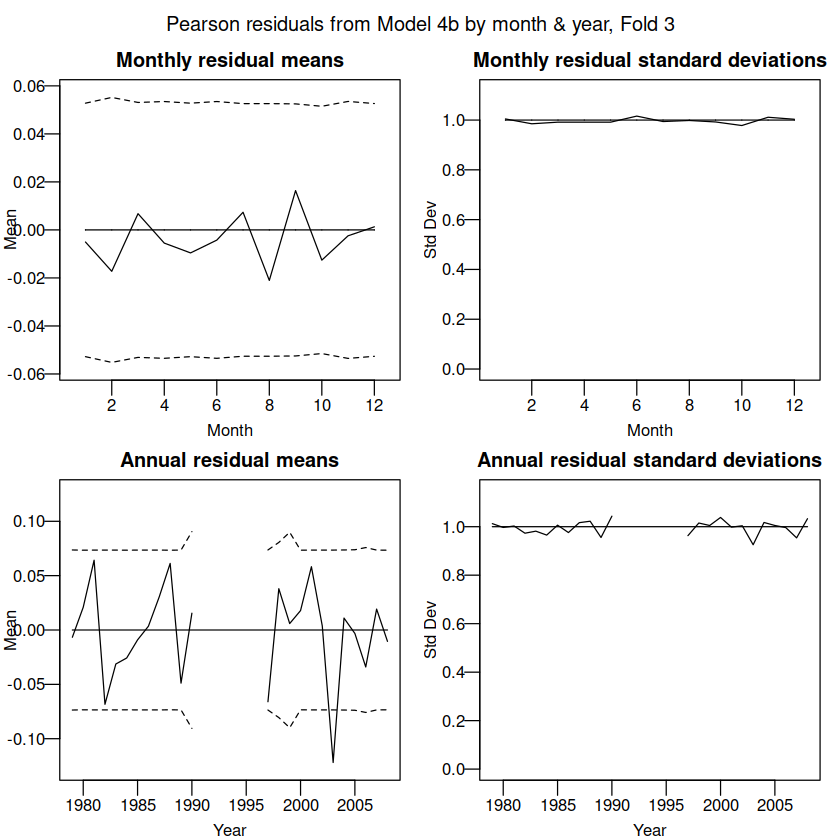

Fitting to data excluding years 1997 to 2002 ...
MODEL 4B

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.8544   0.0349 -53.1575 < 2.2e-16
1                        MappedAltitude      0.0783   0.0037  21.2711 < 2.2e-16
2                    E-W_slope_1000km^2      1.5543   0.2556   6.0803 1.200e-09
3                     N-S_slope_100km^2      0.3056   0.0805   3.7975 0.0001461
4  Daily annual cycle, cosine component     -0.4112   0.0442  -9.3083 < 2.2e-16
5    Daily annual cycle, sine component     -0.0744   0.0430  -1.7282 0.0839570
6  First harmonic of daily annual cycle      0.1059   0.0245   4.3224 1.544e-05
7  First harmonic of daily annual cycle     -0.0124   0.0245  -0.5055 0.6131802
8  Second harmonic of daily annual cycl      0.0080   0.0244   0.3276 0.7432447
9  Second harmonic of daily annual cycl     -0.0370   0.0246  -1.5034 0.1327480
10 Di

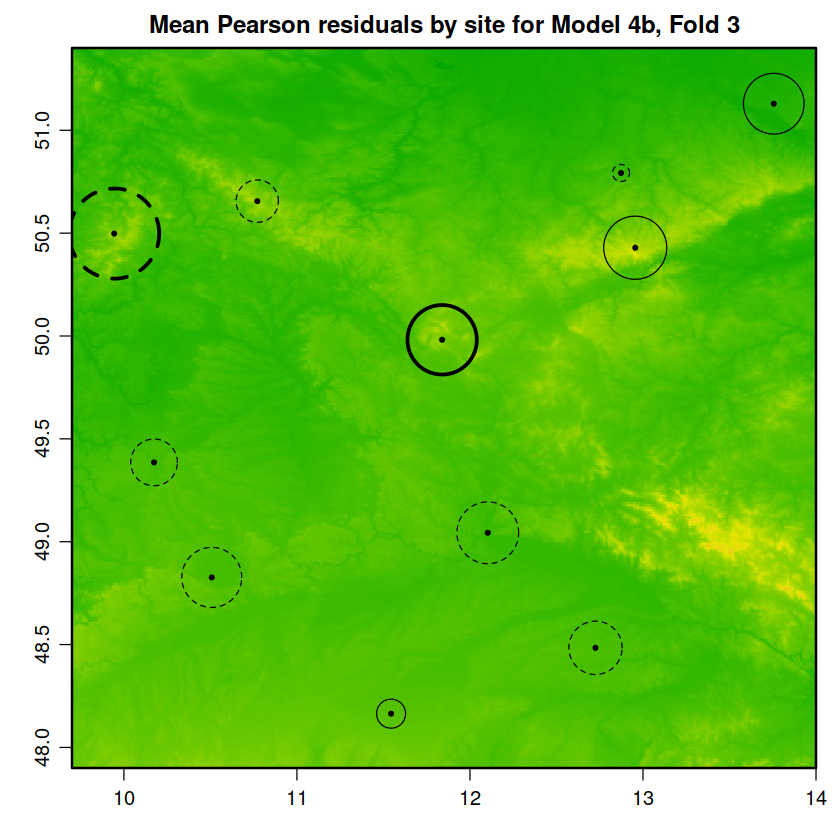


Linear trend model for annual mean residuals from Model 4b:

Call:
lm(formula = MeanRes ~ Year)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.10283 -0.02328  0.00721  0.02772  0.06913 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.0101593  0.0116749  -0.870    0.394
Year        -0.0008437  0.0009673  -0.872    0.393

Residual standard error: 0.04283 on 22 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.03342,	Adjusted R-squared:  -0.01051 
F-statistic: 0.7608 on 1 and 22 DF,  p-value: 0.3925



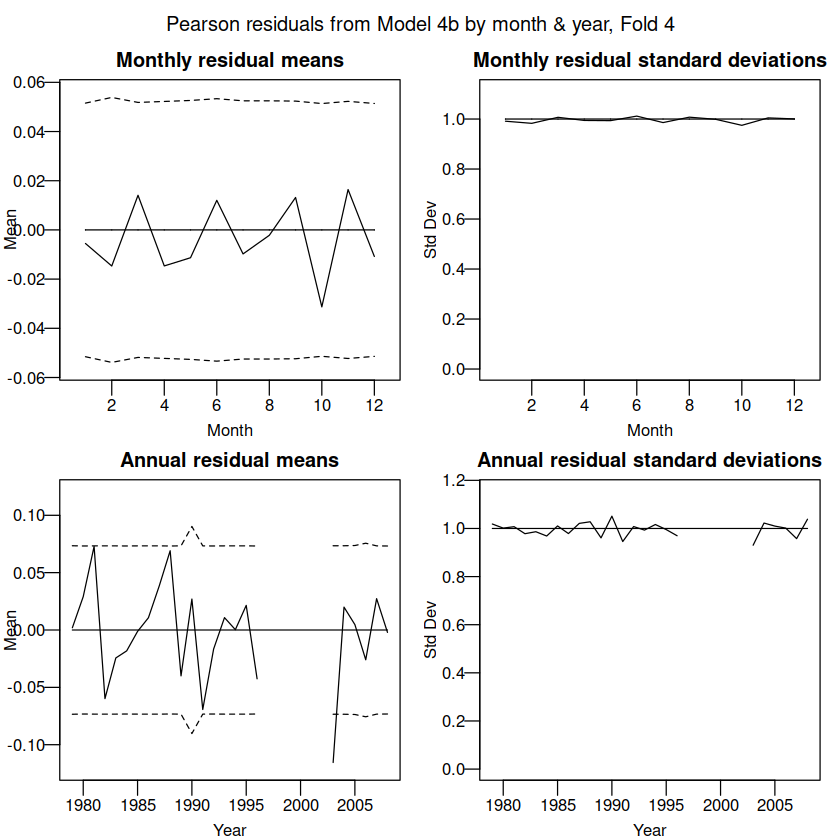

Fitting to data excluding years 2003 to 2008 ...
MODEL 4B

Response variable: Precip 

Main effects:
-------------
                                        Coefficient  Std Err   Z-stat Pr(|Z|>z)
                               Constant     -1.8392   0.0351 -52.4330 < 2.2e-16
1                        MappedAltitude      0.0799   0.0037  21.4093 < 2.2e-16
2                    E-W_slope_1000km^2      1.3611   0.2565   5.3065 1.117e-07
3                     N-S_slope_100km^2      0.4719   0.0816   5.7870 7.167e-09
4  Daily annual cycle, cosine component     -0.3611   0.0441  -8.1807 2.822e-16
5    Daily annual cycle, sine component     -0.1025   0.0431  -2.3796  0.017332
6  First harmonic of daily annual cycle      0.0789   0.0245   3.2213  0.001276
7  First harmonic of daily annual cycle     -0.0205   0.0246  -0.8335  0.404574
8  Second harmonic of daily annual cycl     -0.0288   0.0245  -1.1776  0.238960
9  Second harmonic of daily annual cycl     -0.0380   0.0247  -1.5402  0.123505
10 Di

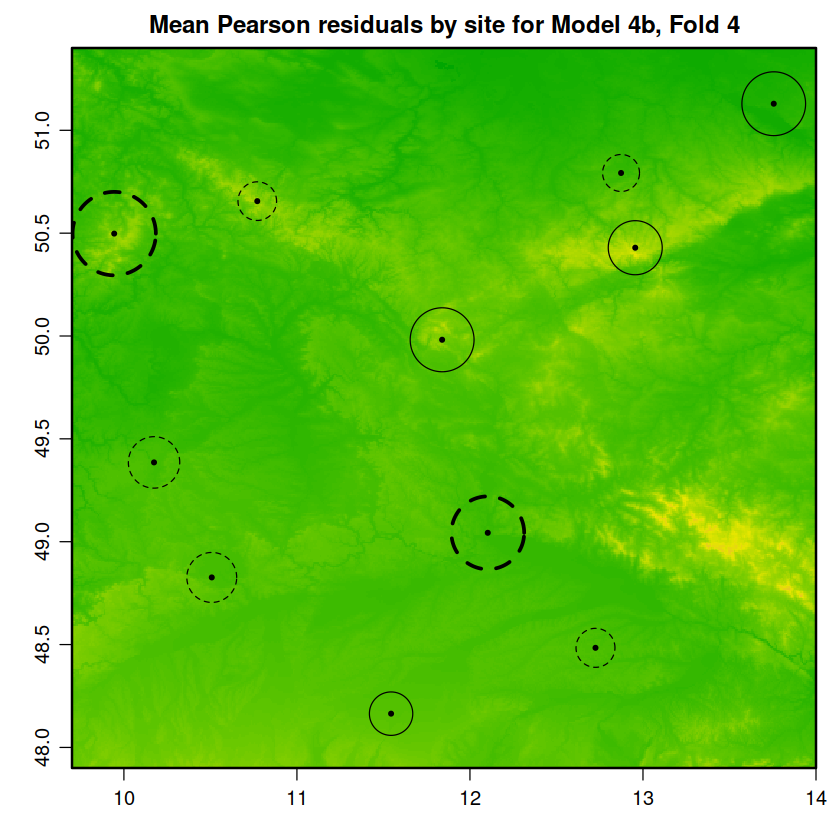


Linear trend model for annual mean residuals from Model 4b:

Call:
lm(formula = MeanRes ~ Year)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.073851 -0.023362  0.003293  0.021184  0.071055 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.0006841  0.0141211   0.048    0.962
Year        0.0003805  0.0012013   0.317    0.754

Residual standard error: 0.04074 on 22 degrees of freedom
Multiple R-squared:  0.004539,	Adjusted R-squared:  -0.04071 
F-statistic: 0.1003 on 1 and 22 DF,  p-value: 0.7544



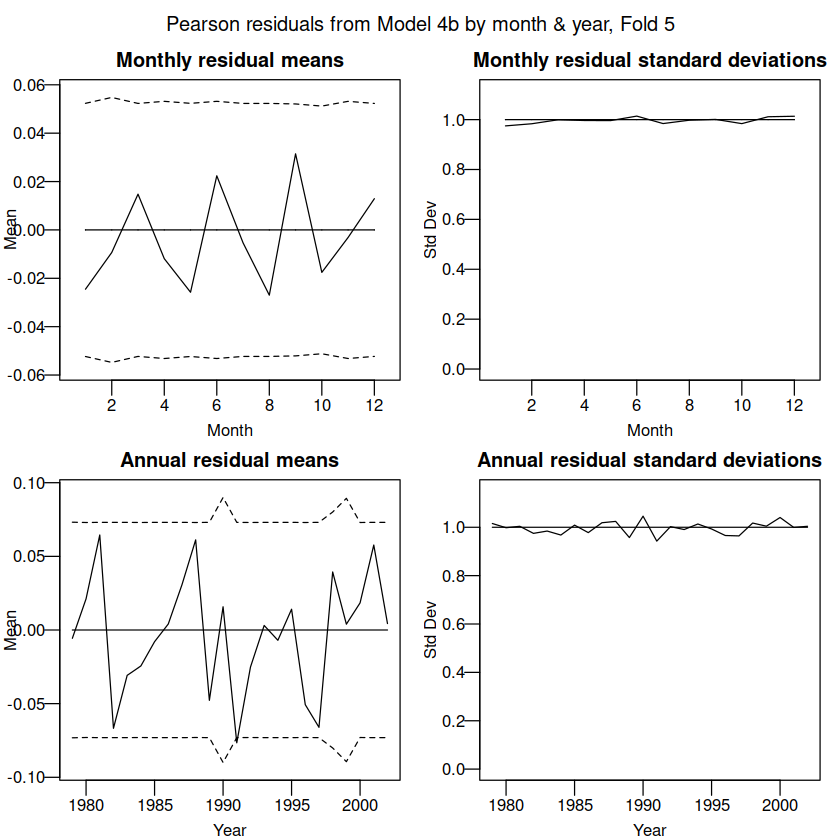

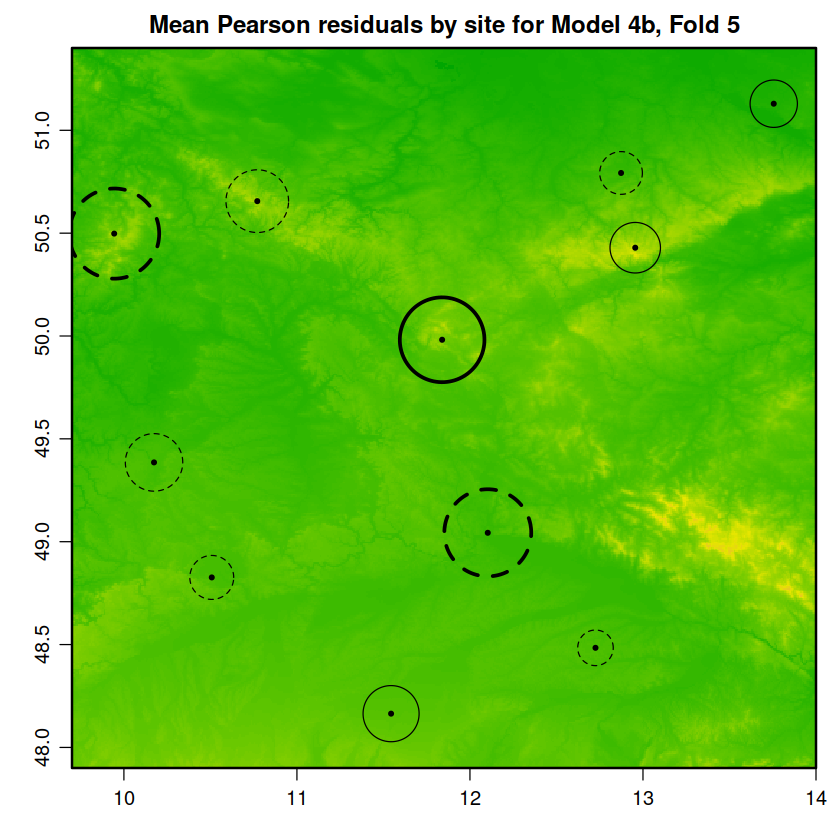

In [14]:
Model4b.Init <- read.modeldef("Rglimclim_files/DEFINITIONS/Model4bInit.def", 
                             model.type = "logistic", siteinfo=stations,
                             var.names = "Precip", oldGlimClim.warning=FALSE)
for (Fold in 1:NFolds) {
  YearsToExclude <- Folds$First[Fold]:Folds$Last[Fold]
  cat(paste("Fitting to data excluding years",min(YearsToExclude),"to",
            max(YearsToExclude),"...\n"))
  write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
                file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
  FittedModels[[Fold]]$Model4b <- 
    GLCfit(Model4b.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
           model.type="logistic", diagnostics=1, nprev.required=1,
           verbosity=0)
  print(FittedModels[[Fold]]$Model4b)
  cat("\nComparison of models 3c, 4a and 4b:\n")
  print(anova(FittedModels[[Fold]]$Model3_1c, 
              FittedModels[[Fold]]$Model4a, 
              FittedModels[[Fold]]$Model4b))
  cat("\nSummary of model 4b:\n")
  print(summary(FittedModels[[Fold]]$Model4b, tables=NULL))
  par(mfrow=c(2,2), mar=c(3,3,2,1), mgp=c(2,0.75,0), oma=c(0,0,2,0))
  plot(FittedModels[[Fold]]$Model4b, which.plots=1:2)
  mtext(paste("Pearson residuals from Model 4b by month & year, Fold",
              Fold), outer=TRUE, line=0.25)
  cat("\nLinear trend model for annual mean residuals from Model 4b:\n")
  tmp <- FittedModels[[Fold]]$Model4b$Residuals$Pearson$Year.table
  MeanRes <- tmp$Mean; Year <- (as.numeric(rownames(tmp))-2000)
  print(summary(lm(MeanRes ~ Year)))
  par(mfrow=c(1,1), oma=c(0,0,0,0), ask=FALSE)
  DrawMap(LongLims,LatLims)
  plot(FittedModels[[Fold]]$Model4b,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=1),
     title=FALSE)
  title(paste("Mean Pearson residuals by site for Model 4b, Fold", Fold))
}


A few comments on these results: 

* The results for all folds are qualitatively similar in all important respects, although there is some variation between folds in the maps of mean Pearson residuals by site (there are typically two or three sites with mean residuals that differ significantly from zero at the 5% level, but these vary between folds and, for each individual fold, it's hard to see what can be done about it).
* For all folds, there is some disagreement between observed and expected wet-day frequencies when the predicted probabilities are between 0.3 and 0.4: the reason for this isn't clear. The probabilistic calibration seems good for all other deciles, however. 
* There's no obvious trend in the residuals for any fold, although 2003 stands out as an unusually dry year for all folds using its data. The absence of trend is tentatively confirmed by the $p$-values for linear trend models fitted to the annual series of residuals for each fold: the lowest $p$-value is 0.393, for Fold 4.

Overall, the conclusion here is that the structure of Model 4b seems appropriate for all folds as a "baseline" model. Can now start to consider the large-scale atmospheric covariates, therefore. 



## Analysis of atmospheric predictors

There are 20 predictors in total, and many of them will be strongly correlated with each other. Start by producing time series plots of annual means for all of them, just to check that there's nothing (e.g.) with clear trends --- given that there are no obvious trends in the residuals from the baseline model. 


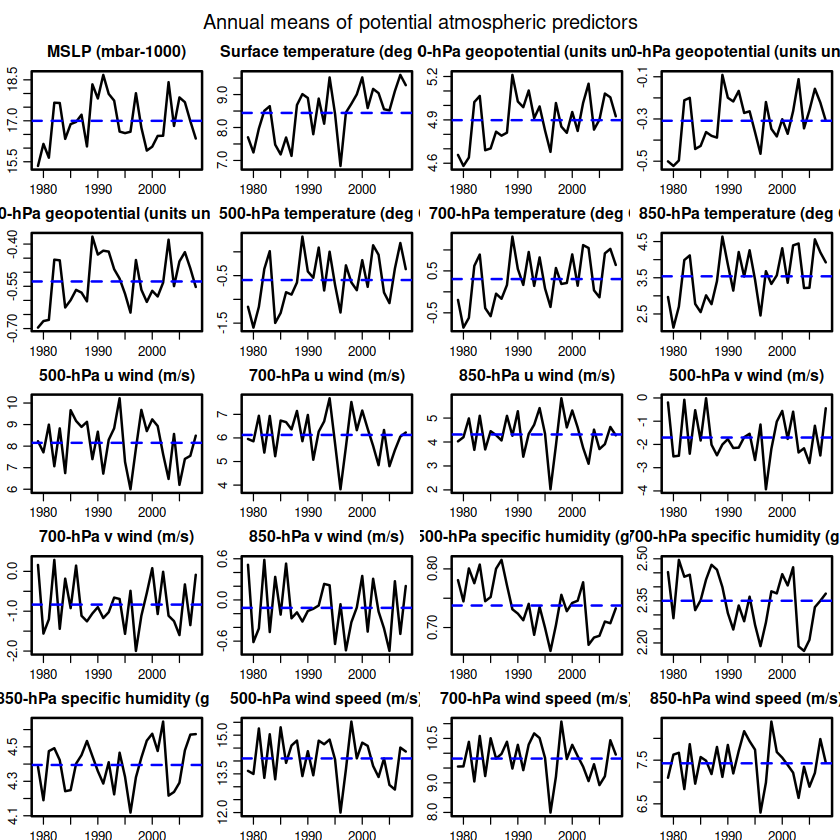

In [15]:
PredictorData <- read.table("Rglimclim_files/DailyPreds_Averaged.dat", header=FALSE, skip=63)
names(PredictorData) <- c("Date", 
                          scan("Rglimclim_files/DailyPreds_Averaged.dat", 
                               what=character(), sep="\n", 
                               skip=42, n=20))
PredictorData <- aggregate(PredictorData[,-1], 
                           by = list(Year=PredictorData$Date %/% 1e4), 
                           FUN=mean)
par(mfrow=c(5,4), mar=c(1.5,2,2.5,0.5), mgp=c(2,0.75,0), lwd=2, 
    oma=c(0,0,2,0), ask=FALSE)
for (i in 1:(ncol(PredictorData)-1)) {
  plot(PredictorData[,c(1,i+1)], type="l", xlab="Year", ylab="")
  abline(h=mean(PredictorData[,i+1]), col="blue", lty=2)
  title(main=names(PredictorData)[i+1])
}
mtext("Annual means of potential atmospheric predictors", side=3, outer=TRUE)

In [16]:
cat("\nLinear trend models fitted to annual means of atmospheric predictors:\n")


Linear trend models fitted to annual means of atmospheric predictors:


In [17]:
summary(lm(as.matrix(PredictorData[,-1]) ~ PredictorData[,1]))

Response MSLP (mbar-1000) :

Call:
lm(formula = `MSLP (mbar-1000)` ~ PredictorData[, 1])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4321 -0.6598 -0.2651  0.7964  1.7200 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)        -13.25394   37.06741  -0.358    0.723
PredictorData[, 1]   0.01518    0.01859   0.816    0.421

Residual standard error: 0.8815 on 28 degrees of freedom
Multiple R-squared:  0.02324,	Adjusted R-squared:  -0.01165 
F-statistic: 0.6661 on 1 and 28 DF,  p-value: 0.4213


Response Surface temperature (deg C) :

Call:
lm(formula = `Surface temperature (deg C)` ~ PredictorData[, 
    1])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.74063 -0.41960  0.03209  0.49588  1.05052 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -96.68817   26.10908  -3.703 0.000926 ***
PredictorData[, 1]   0.05274    0.01310   4.027 0.000391 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 

The following predictors have linear trends that are significant at $p=0.05$, which will potentially induce residual trends that are not present in the baseline model: 

* Surface temperature ($p=0.0004$)
* 500hPa geopotential ($p=0.0227$)
* 700hPa geopotential ($p=0.0291$)
* 500Pa temperature ($p=0.0327$)
* 700hPa temperature ($p=0.0101$)
* 850hPa temperature ($p=0.0084$)
* 500hPa specific humidity ($p=0.0004$)
* 700hPa specific humidity ($p=0.0340$)

With the exception of 500hPa temperature, I'll exclude all of these from consideration on the grounds that (a) I don't want to induce trends that don't exist in the precipitation data (b) there's a high degree of collinearity there e.g. a PCA on the scaled data (not shown) reveals that the first 10 PCs explain almost 99\% of the overall variation. The reason for retaining 500hPa temperature is that otherwise _all_ temperature variables would be excluded from consideration, and there are physical reasons for expecting an association between precipitation occurrence and some measure of temperature. Of all the temperature variables, this one has the least significant trend.

## Inclusion of atmospheric predictors in models

Add all of the non-excluded predictors to the final baseline model, plus their interactions with the main seasonal cycle. Then, for each fold, identify any seasonal interaction pairs where the smallest of the two $p$-values is greater than 0.2 (that's a bit arbitrary perhaps --- just trying identify terms that are unlikely to be contributing anything).  

In [18]:
FindCandidateDeletions <- function(Model, p) {
    #
    #   Function to take a fitted model and identify candidate interactions
    #   to delete, based on *both* of the seasonal interaction terms
    #   having p-values greater than p.
    #
    zvals <- (Model$beta / sqrt(diag(Model$cov.robust)))[-1]
    which.terms <- 
      which(Model$twoway[,1] %in% 11:30 & abs(zvals) < qnorm(1-(p/2)))
    tmp <- table(Model$twoway[which.terms,1]) 
    ToDrop <- 1 +                    # Indices of main effects for which
      as.numeric(names(tmp))[tmp==2] # both interaction terms have p>0.1
    cat("Seasonal interactions to drop are with:\n")
    cat(paste(paste("  ",Model$model.labels$xlabels[ToDrop]),collapse="\n"))
  }

### Model 5A


In [19]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5aInit.def")) {
  write.modeldef(FittedModels$Fold1$Model4b,
                 file="Rglimclim_files/DEFINITIONS/Model5aInit.def")
}
Model5a.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5aInit.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
for (Fold in 1:NFolds) {
  YearsToExclude <- Folds$First[Fold]:Folds$Last[Fold]
  cat(paste("Fitting to data excluding years",min(YearsToExclude),"to",
            max(YearsToExclude),"...\n"))
  write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
                file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
  FittedModels[[Fold]]$Model5a <- 
    GLCfit(Model5a.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
           model.type="logistic", diagnostics=1, nprev.required=1,
           verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
  FindCandidateDeletions(FittedModels[[Fold]]$Model5a, 0.2)
  cat("\n\n")
}

Fitting to data excluding years 1979 to 1984 ...
Seasonal interactions to drop are with:
   500-hPa u wind (m/s)

Fitting to data excluding years 1985 to 1990 ...
Seasonal interactions to drop are with:
   500-hPa u wind (m/s)

Fitting to data excluding years 1991 to 1996 ...
Seasonal interactions to drop are with:
   500-hPa wind speed (m/s)

Fitting to data excluding years 1997 to 2002 ...
Seasonal interactions to drop are with:
   

Fitting to data excluding years 2003 to 2008 ...
Seasonal interactions to drop are with:
   500-hPa wind speed (m/s)




OK: so there are _no_ suggested deletions that are common to all folds. It's time to look at each fold individually. For each fold, check for opportunities to remove terms from the model; and also check for unreasonably large coefficients or standard errors that might indicate overfitting.

### Finalising model for Fold 1

At this stage, no main effects can be removed without considering the corresponding interactions. Look for candidate interactions to delete therefore, now using a less cautious $p$-value criterion of 0.05. 

In [20]:
print(FittedModels$Fold1$Model5a)
FindCandidateDeletions(FittedModels$Fold1$Model5a, 0.05)

MODEL 5A

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.2866   0.5465 -22.4830 < 2.2e-16
1                       MappedAltitude      0.1076   0.0043  24.9574 < 2.2e-16
2                   E-W_slope_1000km^2      1.8831   0.3229   5.8320 5.475e-09
3                    N-S_slope_100km^2      0.4731   0.0999   4.7367 2.173e-06
4  Daily annual cycle, cosine componen     -3.8115   0.7001  -5.4443 5.200e-08
5   Daily annual cycle, sine component     -0.7347   0.7012  -1.0479  0.294684
6  First harmonic of daily annual cycl      0.0690   0.0429   1.6083  0.107768
7  First harmonic of daily annual cycl      0.2220   0.0476   4.6644 3.094e-06
8  Second harmonic of daily annual cyc     -0.0855   0.0264  -3.2419  0.001187
9  Second harmonic of daily annual cyc     -0.0477   0.0259  -1.8433  0.065288
10 Distance-weighted mean of I(Precip[      0.1802   0.0548   3.2

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   500-hPa wind speed (m/s)
   700-hPa wind speed (m/s)


I won't remove a $u$-wind component with removing the corresponding $v$ component; so at this stage the candidates for deletion are the interactions involving 500hPa and 700hPa wind speed. Copy definition file from Model 5a and edit. 


In [21]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5bFold1Init.def")) {
  write.modeldef(FittedModels$Fold1$Model5a, 
                 "Rglimclim_files/DEFINITIONS/Model5bFold1Init.def")
}
Model5b.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5bFold1Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
YearsToExclude <- Folds$First[1]:Folds$Last[1]
write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
              file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
FittedModels$Fold1$Model5b <- 
  GLCfit(Model5b.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold1$Model5a, FittedModels$Fold1$Model5b))
cat("\n")

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD1 - MODEL 5B

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          92692         -45102.04                                        
M1 vs M2    92696       4 -45151.91 49.868 < 2.22e-16     11.897 8.7847e-05



The reduction in performance is significant, but how does it affect the predicted probabilities?


In [22]:
print(summary(FittedModels$Fold1$Model5a, tables=NULL))
print(summary(FittedModels$Fold1$Model5b, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 92752 observations

# of parameters estimated: 60          Independence log-likelihood: -45102.04
Residual degrees of freedom: 92692     Deviance: 90204.08            
Mean squared error (mean Brier score): 0.1623


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0078 (std err 0.0068), standard deviation 0.9810

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.036 0.144 0.262 0.370 0.471 0.552 0.642 0.732 0.820 0.927
Expected prop.  0.047 0.148 0.249 0.348 0.450 0.550 0.650 0.748 0.847 0.932
Number of cases 19004 14005 11544  9793  9093  8014  7681  6709  4959  1950
NULL
FOLD1 - MODEL 5B

Response variable: Precip 

Model of type 'logistic', fitted to 92752 observations

# of parameters estimated: 56          Inde


Answer: very little. Note in particular that the Brier score goes up from 0.1623 to 0.1625. Also, there is quite good agreement between the observed and expected proportions of wet days across all deciles. 

Next: are there any other candidate interactions for deletion? Set a $p$-value threshold of 0.01 now:


In [23]:
FindCandidateDeletions(FittedModels$Fold1$Model5b, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   850-hPa wind speed (m/s)

OK: remove the 850hPa wind speed interactions (just copy the initial definition file for Model 5b and delete the relevant rows).


In [24]:
Model5c.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5cFold1Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold1$Model5c <- 
  GLCfit(Model5c.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold1$Model5a, FittedModels$Fold1$Model5c))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD1 - MODEL 5C

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          92692         -45102.04                                        
M1 vs M2    92698       6 -45156.58 54.544 < 2.22e-16     12.869 0.00024906


In [25]:
FindCandidateDeletions(FittedModels$Fold1$Model5c, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   850-hPa u wind (m/s)

In [26]:
print(FittedModels$Fold1$Model5c)

FOLD1 - MODEL 5C

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.4630   0.5465 -22.8066 < 2.2e-16
1                       MappedAltitude      0.1078   0.0043  25.0473 < 2.2e-16
2                   E-W_slope_1000km^2      1.8903   0.3228   5.8558 4.747e-09
3                    N-S_slope_100km^2      0.4741   0.0998   4.7516 2.019e-06
4  Daily annual cycle, cosine componen     -3.8106   0.7025  -5.4247 5.807e-08
5   Daily annual cycle, sine component     -0.6859   0.7014  -0.9780 0.3280900
6  First harmonic of daily annual cycl      0.0623   0.0427   1.4611 0.1440015
7  First harmonic of daily annual cycl      0.2122   0.0474   4.4746 7.655e-06
8  Second harmonic of daily annual cyc     -0.0812   0.0264  -3.0773 0.0020887
9  Second harmonic of daily annual cyc     -0.0443   0.0259  -1.7115 0.0869973
10 Distance-weighted mean of I(Precip[      0.1786   0.05

Looks like the main effects of all the wind speed variables can probably go as well. Again, just copy the existing definition file and remove them. 


In [27]:
Model5d.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5dFold1Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold1$Model5d <- 
  GLCfit(Model5d.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold1$Model5a, FittedModels$Fold1$Model5d))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD1 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          92692         -45102.04                                         
M1 vs M2    92701       9 -45222.70 120.662 < 2.22e-16     27.679 1.0409e-08


In [28]:
FindCandidateDeletions(FittedModels$Fold1$Model5d, 0.01)

Seasonal interactions to drop are with:
   850-hPa u wind (m/s)

In [29]:
print(summary(FittedModels$Fold1$Model5a, tables=NULL))
print(summary(FittedModels$Fold1$Model5d, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 92752 observations

# of parameters estimated: 60          Independence log-likelihood: -45102.04
Residual degrees of freedom: 92692     Deviance: 90204.08            
Mean squared error (mean Brier score): 0.1623


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0078 (std err 0.0068), standard deviation 0.9810

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.036 0.144 0.262 0.370 0.471 0.552 0.642 0.732 0.820 0.927
Expected prop.  0.047 0.148 0.249 0.348 0.450 0.550 0.650 0.748 0.847 0.932
Number of cases 19004 14005 11544  9793  9093  8014  7681  6709  4959  1950
NULL
FOLD1 - MODEL 5D

Response variable: Precip 

Model of type 'logistic', fitted to 92752 observations

# of parameters estimated: 51          Inde

The fit is worse, but actually the probabilistic calibration is slightly improved(!). What does the model look like now? 


In [30]:
print(FittedModels$Fold1$Model5d)

FOLD1 - MODEL 5D

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.5067   0.5484 -22.8075 < 2.2e-16
1                       MappedAltitude      0.1065   0.0043  24.6992 < 2.2e-16
2                   E-W_slope_1000km^2      1.8630   0.3219   5.7869 7.170e-09
3                    N-S_slope_100km^2      0.4688   0.0996   4.7043 2.548e-06
4  Daily annual cycle, cosine componen     -3.7827   0.7040  -5.3729 7.750e-08
5   Daily annual cycle, sine component     -0.6310   0.7035  -0.8969 0.3697505
6  First harmonic of daily annual cycl      0.0583   0.0427   1.3652 0.1721997
7  First harmonic of daily annual cycl      0.2147   0.0474   4.5301 5.895e-06
8  Second harmonic of daily annual cyc     -0.0857   0.0264  -3.2427 0.0011842
9  Second harmonic of daily annual cyc     -0.0476   0.0259  -1.8389 0.0659360
10 Distance-weighted mean of I(Precip[      0.1895   0.05

That looks OK: nothing more to remove. What about adding external: regional and lag interactions? 


In [31]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5eFold1Init.def")) {
  write.modeldef(FittedModels$Fold1$Model5d, 
                 "Rglimclim_files/DEFINITIONS/Model5eFold1Init.def")
}
Model5e.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5eFold1Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold1$Model5e <- 
  GLCfit(Model5e.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold1$Model5d, FittedModels$Fold1$Model5e))
cat("\n")
print(FittedModels$Fold1$Model5e)

Comparison of nested models
---------------------------

Model 1: FOLD1 - MODEL 5E 
Model 2: FOLD1 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          92661         -44268.11                                         
M1 vs M2    92701      40 -45222.70 954.591 < 2.22e-16     392.55 < 2.22e-16

FOLD1 - MODEL 5E

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -11.7238   0.7852 -14.9312 < 2.2e-16
1                       MappedAltitude     -0.0289   0.0797  -0.3630 0.7166042
2                   E-W_slope_1000km^2      2.2480   7.7974   0.2883 0.7731115
3                    N-S_slope_100km^2      1.0873   2.3637   0.4600 0.6455118
4  Daily annual cycle, cosine componen     -5.0572   0.7472  -6.7678 1.307e-11
5   Daily annual cycle, sine component     -0.4811   0.7101  -0.6776 0.4980469
6  First harmonic of daily ann

There's some improvement there, but many of the additional interactions are insignificant: prune back again, therefore. I'm going to use a fairly small $p$-value threshold of 0.001 here because I don't want too many interactions in the final model; but as usual, I'll consider the $u$ and $v$ wind terms in pairs (also the E-W and N-S slopes).

In [32]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5fFold1Init.def")) {
  write.modeldef(FittedModels$Fold1$Model5e, 
                 "Rglimclim_files/DEFINITIONS/Model5fFold1Init.def")
}
Model5f.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5fFold1Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold1$Model5f <- 
  GLCfit(Model5f.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold1$Model5e, FittedModels$Fold1$Model5f, 
            FittedModels$Fold1$Model5d))

Comparison of nested models
---------------------------

Model 1: FOLD1 - MODEL 5E 
Model 2: FOLD1 - MODEL 5F 
Model 3: FOLD1 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          92661         -44268.11                                         
M1 vs M2    92681      20 -44385.88 117.765 < 2.22e-16     41.495 1.2133e-09
M2 vs M3    92701      20 -45222.70 836.825 < 2.22e-16    351.055 < 2.22e-16


As expected, it's a worse fit but for 20 fewer parameters I think it's worth it. It's still a big improvement over Model 5d. Look for more terms to remove: 


In [33]:
print(FittedModels$Fold1$Model5f)

FOLD1 - MODEL 5F

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.0527   0.5874 -22.2226 < 2.2e-16
1                       MappedAltitude      0.0993   0.0059  16.9198 < 2.2e-16
2                   E-W_slope_1000km^2     -0.8978   0.4799  -1.8709  0.061363
3                    N-S_slope_100km^2      0.1594   0.1535   1.0381  0.299219
4  Daily annual cycle, cosine componen     -4.7764   0.7456  -6.4063 1.491e-10
5   Daily annual cycle, sine component     -0.5541   0.7274  -0.7617  0.446242
6  First harmonic of daily annual cycl      0.0505   0.0434   1.1637  0.244533
7  First harmonic of daily annual cycl      0.2296   0.0479   4.7978 1.604e-06
8  Second harmonic of daily annual cyc     -0.0857   0.0266  -3.2254  0.001258
9  Second harmonic of daily annual cyc     -0.0453   0.0262  -1.7302  0.083603
10 Distance-weighted mean of I(Precip[      0.1633   0.22


It now looks as though we don't need the seasonality:topography interactions.  Also, it looks as though we're now getting close to final model for this fold so replace the spatial correlation structure with something more realistic. 


In [34]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5gFold1Init.def")) {
  write.modeldef(FittedModels$Fold1$Model5f, 
                 "Rglimclim_files/DEFINITIONS/Model5gFold1Init.def")
}
Model5g.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5gFold1Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold1$Model5g <- 
  GLCfit(Model5g.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"),
         cor.file="Rglimclim_files/Fold1Corr.dat", )
print(anova(FittedModels$Fold1$Model5f, FittedModels$Fold1$Model5g))

Comparison of nested models
---------------------------

Model 1: FOLD1 - MODEL 5F 
Model 2: FOLD1 - MODEL 5G

         Resid DF DF2-DF1      LogL   LLR          p Robust LLR   Robust p
M1          92681         -44385.88                                       
M1 vs M2    92687       6 -44393.73 7.852 0.01543604     12.414 0.00036744


In [35]:
print(FittedModels$Fold1$Model5g)

FOLD1 - MODEL 5G

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.0700   0.5868 -22.2737 < 2.2e-16
1                       MappedAltitude      0.0992   0.0058  16.9563 < 2.2e-16
2                   E-W_slope_1000km^2     -0.8674   0.4785  -1.8128  0.069865
3                    N-S_slope_100km^2      0.1385   0.1534   0.9026  0.366737
4  Daily annual cycle, cosine componen     -4.8191   0.7423  -6.4918 8.480e-11
5   Daily annual cycle, sine component     -0.6659   0.7257  -0.9176  0.358844
6  First harmonic of daily annual cycl      0.0512   0.0434   1.1796  0.238178
7  First harmonic of daily annual cycl      0.2299   0.0479   4.8048 1.549e-06
8  Second harmonic of daily annual cyc     -0.0854   0.0266  -3.2156  0.001302
9  Second harmonic of daily annual cyc     -0.0454   0.0262  -1.7327  0.083143
10 Distance-weighted mean of I(Precip[      0.1401   0.22

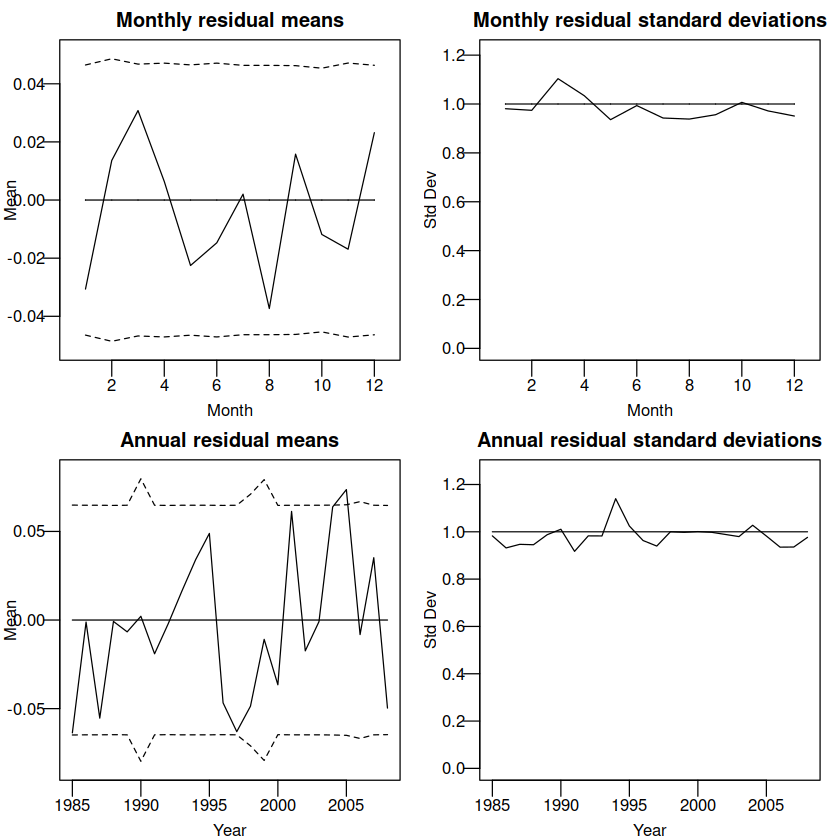

In [36]:
#
#   Let's do residual plots now, and think about inter-site correlation
#
par(mfrow=c(2,2), mar=c(3,3,2,1), mgp=c(2,0.75,0))
plot(FittedModels$Fold1$Model5g, which.plots=1:2)

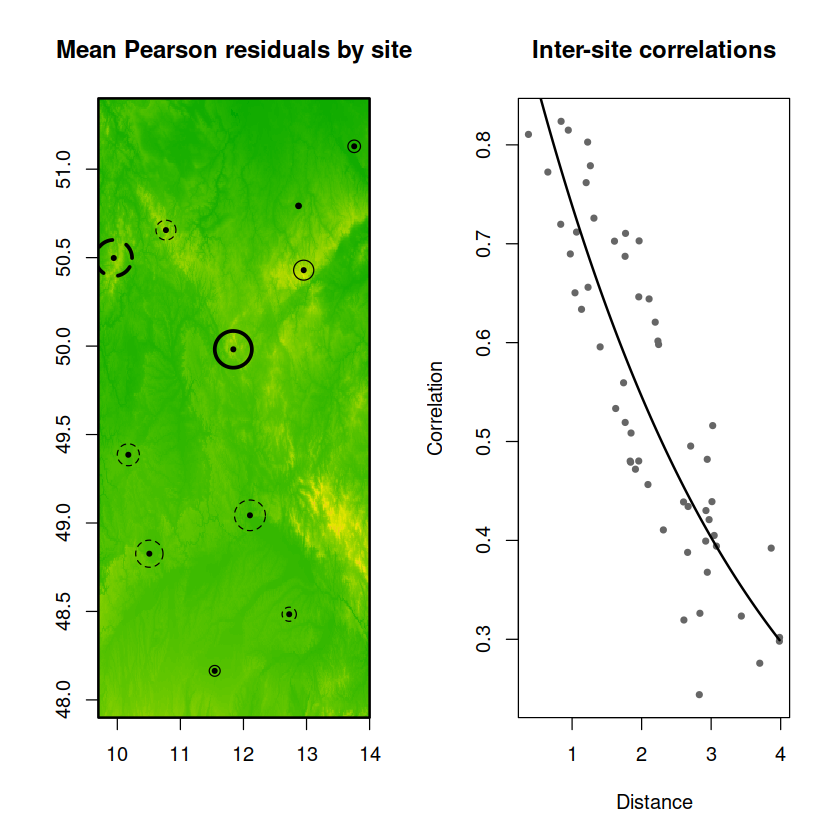

In [37]:
par(mfrow=c(1,2))
DrawMap(LongLims,LatLims)
plot(FittedModels$Fold1$Model5g,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=1))
plot(FittedModels$Fold1$Model5g, which.plots=5)

The exponential correlation model looks pretty good. There are a couple of terms that could potentially be removed, but they're not doing any harm. This is the final model for Fold 1, therefore. 

In [38]:
FinalModels$Fold1 <- FittedModels$Fold1$Model5g


### Finalising model for Fold 2

Look for candidate interactions to delete from Model 5a.

In [39]:
print(FittedModels$Fold2$Model5a)

MODEL 5A

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.9148   0.5557 -23.2411 < 2.2e-16
1                       MappedAltitude      0.1109   0.0043  25.6915 < 2.2e-16
2                   E-W_slope_1000km^2      1.9818   0.3162   6.2669 3.683e-10
3                    N-S_slope_100km^2      0.5046   0.0995   5.0743 3.889e-07
4  Daily annual cycle, cosine componen     -3.6201   0.7059  -5.1285 2.920e-07
5   Daily annual cycle, sine component     -1.2625   0.7210  -1.7511  0.079931
6  First harmonic of daily annual cycl      0.0404   0.0435   0.9299  0.352420
7  First harmonic of daily annual cycl      0.2179   0.0477   4.5681 4.921e-06
8  Second harmonic of daily annual cyc     -0.0506   0.0261  -1.9384  0.052570
9  Second harmonic of daily annual cyc     -0.0456   0.0261  -1.7481  0.080438
10 Distance-weighted mean of I(Precip[      0.1566   0.0484   3.2

In [40]:
FindCandidateDeletions(FittedModels$Fold2$Model5a, 0.05)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   500-hPa wind speed (m/s)
   700-hPa wind speed (m/s)

Candidates for deletion are the interactions involving 500hPa and 700hPa wind speed (not $u$ wind, because $v$ wind is significant). Copy definition file from Model 5a and edit. 

In [41]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5bFold2Init.def")) {
  write.modeldef(FittedModels$Fold2$Model5a, 
                 "Rglimclim_files/DEFINITIONS/Model5bFold2Init.def")
}
Model5b.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5bFold2Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
YearsToExclude <- Folds$First[2]:Folds$Last[2]
write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
              file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
FittedModels$Fold2$Model5b <- 
  GLCfit(Model5b.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold2$Model5a, FittedModels$Fold2$Model5b))
cat("\n")

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 2 - MODEL 5B

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          94056         -45714.53                                        
M1 vs M2    94060       4 -45779.50 64.975 < 2.22e-16     15.438 3.2462e-06



Check changes in predicted probabilities & Brier score:


In [42]:
print(summary(FittedModels$Fold2$Model5a, tables=NULL))
print(summary(FittedModels$Fold2$Model5b, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 94116 observations

# of parameters estimated: 60          Independence log-likelihood: -45714.53
Residual degrees of freedom: 94056     Deviance: 91429.05            
Mean squared error (mean Brier score): 0.1619


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0068 (std err 0.0068), standard deviation 0.9847

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.036 0.149 0.257 0.363 0.472 0.553 0.639 0.735 0.823 0.929
Expected prop.  0.047 0.149 0.249 0.348 0.449 0.549 0.649 0.748 0.847 0.932
Number of cases 19333 14417 11872 10076  8996  8300  7561  6638  4898  2025
NULL
FOLD 2 - MODEL 5B

Response variable: Precip 

Model of type 'logistic', fitted to 94116 observations

# of parameters estimated: 56          Ind

Nothing to worry about there. Check other candidate interactions for deletion, using $p$-value threshold of 0.01:


In [43]:
FindCandidateDeletions(FittedModels$Fold2$Model5b, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   850-hPa wind speed (m/s)

850hPa wind speed interaction can go now (just copy the initial definition file for Model 5b and delete the relevant rows).


In [44]:
Model5c.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5cFold2Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold2$Model5c <- 
  GLCfit(Model5c.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold2$Model5a, FittedModels$Fold2$Model5c))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 2 - MODEL 5C

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          94056         -45714.53                                        
M1 vs M2    94062       6 -45781.72 67.196 < 2.22e-16     15.771 1.9978e-05


In [45]:
FindCandidateDeletions(FittedModels$Fold2$Model5c, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   850-hPa u wind (m/s)

No further interactions to remove, so look for anything else e.g. main effects. 


In [46]:
print(FittedModels$Fold2$Model5c)

FOLD 2 - MODEL 5C

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.1038   0.5554 -23.5914 < 2.2e-16
1                       MappedAltitude      0.1112   0.0043  25.7643 < 2.2e-16
2                   E-W_slope_1000km^2      1.9900   0.3156   6.3050 2.882e-10
3                    N-S_slope_100km^2      0.5056   0.0993   5.0921 3.540e-07
4  Daily annual cycle, cosine componen     -3.5430   0.7089  -4.9980 5.793e-07
5   Daily annual cycle, sine component     -1.2308   0.7216  -1.7056  0.088084
6  First harmonic of daily annual cycl      0.0306   0.0433   0.7075  0.479270
7  First harmonic of daily annual cycl      0.2091   0.0475   4.3989 1.088e-05
8  Second harmonic of daily annual cyc     -0.0462   0.0261  -1.7681  0.077052
9  Second harmonic of daily annual cyc     -0.0426   0.0261  -1.6298  0.103145
10 Distance-weighted mean of I(Precip[      0.1559   0.0

Next step is to remove all wind speed. Again, just copy the existing definition file and remove them. 

In [47]:
Model5d.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5dFold2Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold2$Model5d <- 
  GLCfit(Model5d.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold2$Model5a, FittedModels$Fold2$Model5d))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 2 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          94056         -45714.53                                         
M1 vs M2    94065       9 -45871.09 156.567 < 2.22e-16     37.017 2.4499e-12


In [48]:
FindCandidateDeletions(FittedModels$Fold2$Model5d, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   850-hPa u wind (m/s)

In [49]:
print(summary(FittedModels$Fold2$Model5a, tables=NULL))
print(summary(FittedModels$Fold2$Model5d, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 94116 observations

# of parameters estimated: 60          Independence log-likelihood: -45714.53
Residual degrees of freedom: 94056     Deviance: 91429.05            
Mean squared error (mean Brier score): 0.1619


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0068 (std err 0.0068), standard deviation 0.9847

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.036 0.149 0.257 0.363 0.472 0.553 0.639 0.735 0.823 0.929
Expected prop.  0.047 0.149 0.249 0.348 0.449 0.549 0.649 0.748 0.847 0.932
Number of cases 19333 14417 11872 10076  8996  8300  7561  6638  4898  2025
NULL
FOLD 2 - MODEL 5D

Response variable: Precip 

Model of type 'logistic', fitted to 94116 observations

# of parameters estimated: 51          Ind

As with Fold 1, the fit is worse but the probabilistic calibration is slightly better. What does the model look like now? 


In [50]:
print(FittedModels$Fold2$Model5d)

FOLD 2 - MODEL 5D

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.1267   0.5556 -23.6273 < 2.2e-16
1                       MappedAltitude      0.1096   0.0043  25.4208 < 2.2e-16
2                   E-W_slope_1000km^2      1.9597   0.3155   6.2113 5.255e-10
3                    N-S_slope_100km^2      0.4994   0.0992   5.0360 4.753e-07
4  Daily annual cycle, cosine componen     -3.6058   0.7053  -5.1128 3.175e-07
5   Daily annual cycle, sine component     -1.1717   0.7247  -1.6169 0.1059075
6  First harmonic of daily annual cycl      0.0269   0.0432   0.6243 0.5324062
7  First harmonic of daily annual cycl      0.2103   0.0472   4.4533 8.455e-06
8  Second harmonic of daily annual cyc     -0.0530   0.0261  -2.0322 0.0421293
9  Second harmonic of daily annual cyc     -0.0461   0.0261  -1.7698 0.0767679
10 Distance-weighted mean of I(Precip[      0.1628   0.0

Next, add external: regional and lag interactions.


In [51]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5eFold2Init.def")) {
  write.modeldef(FittedModels$Fold2$Model5d, 
                 "Rglimclim_files/DEFINITIONS/Model5eFold2Init.def")
}
Model5e.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5eFold2Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold2$Model5e <- 
  GLCfit(Model5e.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold2$Model5d, FittedModels$Fold2$Model5e))

Comparison of nested models
---------------------------

Model 1: FOLD 2 - MODEL 5E 
Model 2: FOLD 2 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          94025         -44899.09                                         
M1 vs M2    94065      40 -45871.09 972.005 < 2.22e-16     99.481 < 2.22e-16


In [52]:
print(FittedModels$Fold2$Model5e)

FOLD 2 - MODEL 5E

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.2327   0.8052 -15.1926 < 2.2e-16
1                       MappedAltitude     -0.0889   0.0830  -1.0709 0.2842247
2                   E-W_slope_1000km^2      3.0240   7.9925   0.3784 0.7051654
3                    N-S_slope_100km^2      0.5024   2.4363   0.2062 0.8366130
4  Daily annual cycle, cosine componen     -4.8628   0.7420  -6.5539 5.606e-11
5   Daily annual cycle, sine component     -1.1365   0.7369  -1.5424 0.1229859
6  First harmonic of daily annual cycl      0.0110   0.0442   0.2482 0.8040040
7  First harmonic of daily annual cycl      0.2343   0.0475   4.9280 8.306e-07
8  Second harmonic of daily annual cyc     -0.0497   0.0264  -1.8858 0.0593228
9  Second harmonic of daily annual cyc     -0.0485   0.0263  -1.8418 0.0655094
10 Distance-weighted mean of I(Precip[     -4.2921   1.4

Now prune back the additional interactions using a $p$-value threshold of 0.001 as before.

In [53]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5fFold2Init.def")) {
  write.modeldef(FittedModels$Fold2$Model5e, 
                 "Rglimclim_files/DEFINITIONS/Model5fFold2Init.def")
}
Model5f.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5fFold2Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold2$Model5f <- 
  GLCfit(Model5f.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold2$Model5e, FittedModels$Fold2$Model5f, 
            FittedModels$Fold2$Model5d))

Comparison of nested models
---------------------------

Model 1: FOLD 2 - MODEL 5E 
Model 2: FOLD 2 - MODEL 5F 
Model 3: FOLD 2 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          94025         -44899.09                                         
M1 vs M2    94045      20 -45009.46 110.371 < 2.22e-16     43.612 2.2565e-10
M2 vs M3    94065      20 -45871.09 861.634 < 2.22e-16     55.868 9.4631e-15


Again, it's a worse fit but probably worth the parsimony. Look for more terms to remove: 


In [54]:
print(FittedModels$Fold2$Model5f)

FOLD 2 - MODEL 5F

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.9599   0.6034 -23.1366 < 2.2e-16
1                       MappedAltitude      0.1047   0.0059  17.8537 < 2.2e-16
2                   E-W_slope_1000km^2     -1.4485   0.4674  -3.0990  0.001942
3                    N-S_slope_100km^2      0.4137   0.1497   2.7630  0.005728
4  Daily annual cycle, cosine componen     -4.6444   0.7444  -6.2388 4.408e-10
5   Daily annual cycle, sine component     -1.2024   0.7568  -1.5888  0.112114
6  First harmonic of daily annual cycl      0.0154   0.0439   0.3502  0.726186
7  First harmonic of daily annual cycl      0.2286   0.0477   4.7936 1.638e-06
8  Second harmonic of daily annual cyc     -0.0543   0.0263  -2.0664  0.038790
9  Second harmonic of daily annual cyc     -0.0498   0.0263  -1.8935  0.058291
10 Distance-weighted mean of I(Precip[      0.4060   0.2

Get rid of seasonality:topography interactions and replace the spatial correlation structure with something more realistic. 


In [55]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5gFold2Init.def")) {
  write.modeldef(FittedModels$Fold2$Model5f, 
                 "Rglimclim_files/DEFINITIONS/Model5gFold2Init.def")
}
Model5g.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5gFold2Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold2$Model5g <- 
  GLCfit(Model5g.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"),
         cor.file="Rglimclim_files/Fold2Corr.dat", )
print(anova(FittedModels$Fold2$Model5f, FittedModels$Fold2$Model5g))

Comparison of nested models
---------------------------

Model 1: FOLD 2 - MODEL 5F 
Model 2: FOLD 2 - MODEL 5G

         Resid DF DF2-DF1      LogL   LLR        p Robust LLR Robust p
M1          94045         -45009.46                                   
M1 vs M2    94051       6 -45014.59 5.126 0.114462       7.73 0.016961


In [56]:
print(FittedModels$Fold2$Model5g)

FOLD 2 - MODEL 5G

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.9836   0.6030 -23.1889 < 2.2e-16
1                       MappedAltitude      0.1055   0.0058  18.0557 < 2.2e-16
2                   E-W_slope_1000km^2     -1.3791   0.4662  -2.9581  0.003096
3                    N-S_slope_100km^2      0.3926   0.1497   2.6231  0.008714
4  Daily annual cycle, cosine componen     -4.7272   0.7414  -6.3764 1.813e-10
5   Daily annual cycle, sine component     -1.2466   0.7540  -1.6533  0.098280
6  First harmonic of daily annual cycl      0.0157   0.0439   0.3586  0.719902
7  First harmonic of daily annual cycl      0.2289   0.0477   4.8019 1.571e-06
8  Second harmonic of daily annual cyc     -0.0543   0.0263  -2.0660  0.038833
9  Second harmonic of daily annual cyc     -0.0500   0.0263  -1.9008  0.057326
10 Distance-weighted mean of I(Precip[      0.3877   0.2

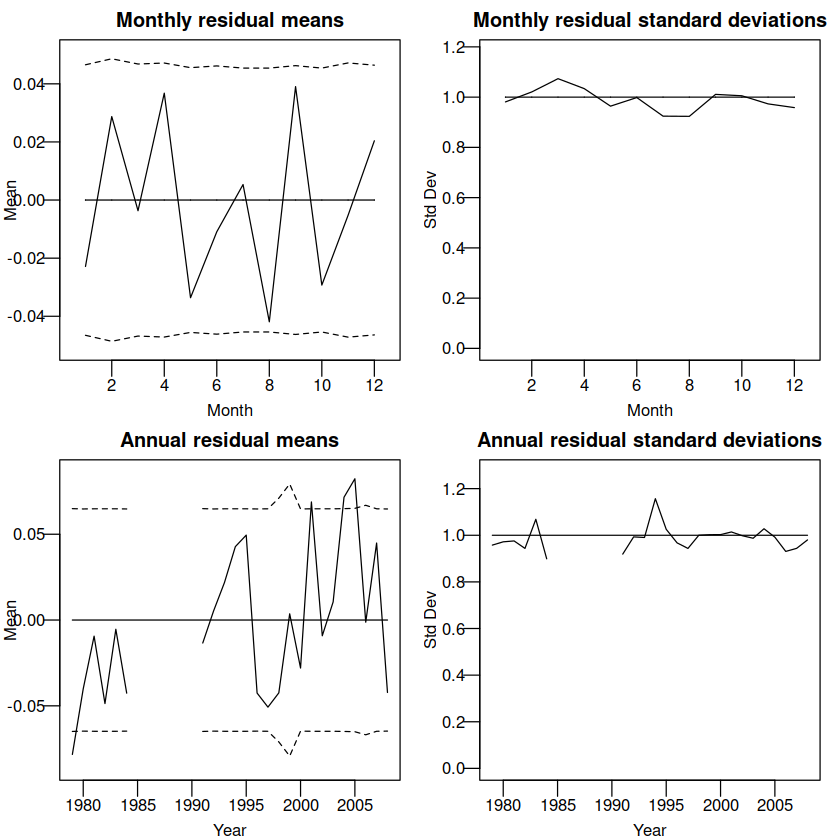

In [57]:
#
#   Let's do residual plots now, and think about inter-site correlation
#
par(mfrow=c(2,2), mar=c(3,3,2,1), mgp=c(2,0.75,0))
plot(FittedModels$Fold2$Model5g, which.plots=1:2)

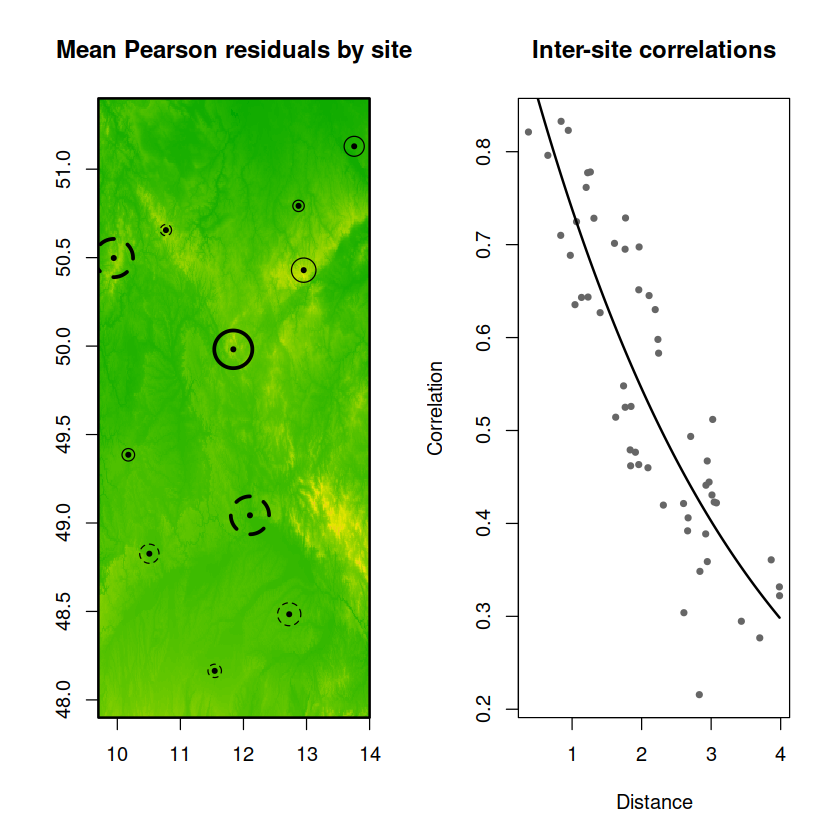

In [58]:
par(mfrow=c(1,2))
DrawMap(LongLims,LatLims)
plot(FittedModels$Fold2$Model5g,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=1))
plot(FittedModels$Fold2$Model5g, which.plots=5)

The exponential correlation model looks good. As with Fold 1, there are a couple of terms that could potentially be removed. There's a more obvious time trend in residuals: this is almost certainly attributable to the inclusion of 500hPa temperature, but it's hard to justify removing this from the model because almost every one of its contributions is very highly significant (and there are good physical reasons for retaining it). This is Fold 2 finished, therefore. 

In [59]:
FinalModels$Fold2 <- FittedModels$Fold2$Model5g


### Finalising model for Fold 3

Look for candidate interactions to delete from Model 5a.

In [60]:
print(FittedModels$Fold3$Model5a)

MODEL 5A

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.9378   0.5663 -22.8469 < 2.2e-16
1                       MappedAltitude      0.1109   0.0043  25.6168 < 2.2e-16
2                   E-W_slope_1000km^2      2.2340   0.3205   6.9697 3.175e-12
3                    N-S_slope_100km^2      0.4414   0.1009   4.3768 1.205e-05
4  Daily annual cycle, cosine componen     -3.1865   0.7182  -4.4371 9.117e-06
5   Daily annual cycle, sine component     -0.8160   0.7316  -1.1154  0.264667
6  First harmonic of daily annual cycl      0.0562   0.0432   1.3015  0.193104
7  First harmonic of daily annual cycl      0.2630   0.0477   5.5187 3.415e-08
8  Second harmonic of daily annual cyc     -0.0299   0.0267  -1.1219  0.261916
9  Second harmonic of daily annual cyc     -0.0320   0.0256  -1.2474  0.212238
10 Distance-weighted mean of I(Precip[      0.1753   0.0539   3.2

In [61]:
FindCandidateDeletions(FittedModels$Fold3$Model5a, 0.05)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   500-hPa wind speed (m/s)


Only candidates for deletion are interactions involving 500hPa wind speed (not $u$ wind, because $v$ wind is significant). Copy definition file from Model 5a and edit. 

In [62]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5bFold3Init.def")) {
  write.modeldef(FittedModels$Fold3$Model5a, 
                 "Rglimclim_files/DEFINITIONS/Model5bFold3Init.def")
}
Model5b.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5bFold3Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
YearsToExclude <- Folds$First[3]:Folds$Last[3]
write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
              file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
FittedModels$Fold3$Model5b <- 
  GLCfit(Model5b.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold3$Model5a, FittedModels$Fold3$Model5b))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 3 - MODEL 5B

         Resid DF DF2-DF1      LogL   LLR       p Robust LLR Robust p
M1          92681         -45289.04                                  
M1 vs M2    92683       2 -45289.96 0.915 0.40050      0.226  0.79807


Check other candidate interactions for deletion, using $p$-value threshold of 0.01:

In [63]:
FindCandidateDeletions(FittedModels$Fold3$Model5b, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)

No further interactions to remove, so look for anything else e.g. main effects. 


In [64]:
print(FittedModels$Fold3$Model5b)

FOLD 3 - MODEL 5B

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.9453   0.5665 -22.8506 < 2.2e-16
1                       MappedAltitude      0.1110   0.0043  25.6201 < 2.2e-16
2                   E-W_slope_1000km^2      2.2358   0.3206   6.9742 3.075e-12
3                    N-S_slope_100km^2      0.4415   0.1009   4.3778 1.199e-05
4  Daily annual cycle, cosine componen     -3.1786   0.7182  -4.4259 9.604e-06
5   Daily annual cycle, sine component     -0.8215   0.7315  -1.1231  0.261399
6  First harmonic of daily annual cycl      0.0565   0.0432   1.3086  0.190668
7  First harmonic of daily annual cycl      0.2621   0.0477   5.4973 3.857e-08
8  Second harmonic of daily annual cyc     -0.0296   0.0267  -1.1106  0.266751
9  Second harmonic of daily annual cyc     -0.0318   0.0256  -1.2428  0.213959
10 Distance-weighted mean of I(Precip[      0.1753   0.0

The only thing to go is the 500hPa wind speed. 


In [65]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5cFold3Init.def")) {
  write.modeldef(FittedModels$Fold3$Model5b, 
                 "Rglimclim_files/DEFINITIONS/Model5cFold3Init.def")
}
Model5c.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5cFold3Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold3$Model5c <- 
  GLCfit(Model5c.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold3$Model5a, FittedModels$Fold3$Model5c))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 3 - MODEL 5C

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR Robust p
M1          92681         -45289.04                                      
M1 vs M2    92684       3 -45303.78 14.735 1.7837e-06      3.555 0.068489


In [66]:
print(FittedModels$Fold3$Model5c)

FOLD 3 - MODEL 5C

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.9840   0.5672 -22.8931 < 2.2e-16
1                       MappedAltitude      0.1107   0.0043  25.5175 < 2.2e-16
2                   E-W_slope_1000km^2      2.2253   0.3202   6.9506 3.638e-12
3                    N-S_slope_100km^2      0.4399   0.1008   4.3639 1.278e-05
4  Daily annual cycle, cosine componen     -3.1589   0.7194  -4.3911 1.128e-05
5   Daily annual cycle, sine component     -0.8270   0.7313  -1.1309 0.2580846
6  First harmonic of daily annual cycl      0.0530   0.0432   1.2275 0.2196222
7  First harmonic of daily annual cycl      0.2585   0.0476   5.4249 5.798e-08
8  Second harmonic of daily annual cyc     -0.0293   0.0267  -1.0975 0.2724429
9  Second harmonic of daily annual cyc     -0.0329   0.0256  -1.2843 0.1990231
10 Distance-weighted mean of I(Precip[      0.1829   0.0

Nothing more to remove there, so add interactions with regional and lag 1 terms. 


In [67]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5dFold3Init.def")) {
  write.modeldef(FittedModels$Fold3$Model5c, 
                 "Rglimclim_files/DEFINITIONS/Model5dFold3Init.def")
}
Model5d.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5dFold3Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold3$Model5d <- 
  GLCfit(Model5d.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold3$Model5c, FittedModels$Fold3$Model5d))

Comparison of nested models
---------------------------

Model 1: FOLD 3 - MODEL 5D 
Model 2: FOLD 3 - MODEL 5C

         Resid DF DF2-DF1      LogL      LLR          p Robust LLR   Robust p
M1          92636         -44290.83                                          
M1 vs M2    92684      48 -45303.78 1012.946 < 2.22e-16    388.367 < 2.22e-16


In [68]:
print(FittedModels$Fold3$Model5d)

FOLD 3 - MODEL 5D

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.0032   0.8410 -14.2725 < 2.2e-16
1                       MappedAltitude     -0.1120   0.0849  -1.3197 0.1869238
2                   E-W_slope_1000km^2     -0.3225   8.2456  -0.0391 0.9688056
3                    N-S_slope_100km^2      1.5212   2.5270   0.6020 0.5471858
4  Daily annual cycle, cosine componen     -4.1410   0.7669  -5.3995 6.683e-08
5   Daily annual cycle, sine component     -0.7041   0.7488  -0.9403 0.3470545
6  First harmonic of daily annual cycl      0.0529   0.0443   1.1934 0.2327076
7  First harmonic of daily annual cycl      0.2832   0.0484   5.8567 4.723e-09
8  Second harmonic of daily annual cyc     -0.0284   0.0269  -1.0558 0.2910669
9  Second harmonic of daily annual cyc     -0.0309   0.0259  -1.1894 0.2342968
10 Distance-weighted mean of I(Precip[     -4.0201   1.4

Now prune back the additional interactions using a $p$-value threshold of 0.001.


In [69]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5eFold3Init.def")) {
  write.modeldef(FittedModels$Fold3$Model5d, 
                 "Rglimclim_files/DEFINITIONS/Model5eFold3Init.def")
}
Model5e.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5eFold3Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold3$Model5e <- 
  GLCfit(Model5e.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold3$Model5d, FittedModels$Fold3$Model5e, 
            FittedModels$Fold3$Model5c))

Comparison of nested models
---------------------------

Model 1: FOLD 3 - MODEL 5D 
Model 2: FOLD 3 - MODEL 5E 
Model 3: FOLD 3 - MODEL 5C

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          92636         -44290.83                                         
M1 vs M2    92664      28 -44451.54 160.704 < 2.22e-16     61.015 1.0462e-13
M2 vs M3    92684      20 -45303.78 852.241 < 2.22e-16    327.352 < 2.22e-16


That's not too bad. Look for more terms to remove: 

In [70]:
print(FittedModels$Fold3$Model5e)

FOLD 3 - MODEL 5E

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.9136   0.6019 -23.1149 < 2.2e-16
1                       MappedAltitude      0.0625   0.0081   7.7586 8.585e-15
2                   E-W_slope_1000km^2     -0.9040   0.4698  -1.9244 0.0543083
3                    N-S_slope_100km^2      0.3457   0.1541   2.2440 0.0248295
4  Daily annual cycle, cosine componen     -3.9319   0.7633  -5.1511 2.589e-07
5   Daily annual cycle, sine component     -0.7360   0.7677  -0.9586 0.3377627
6  First harmonic of daily annual cycl      0.0519   0.0439   1.1801 0.2379750
7  First harmonic of daily annual cycl      0.2780   0.0483   5.7503 8.908e-09
8  Second harmonic of daily annual cyc     -0.0321   0.0269  -1.1938 0.2325574
9  Second harmonic of daily annual cyc     -0.0338   0.0259  -1.3061 0.1915260
10 Distance-weighted mean of I(Precip[      0.8521   0.0

Get rid of seasonality:topography interactions and replace the spatial correlation structure with something more realistic. 


In [71]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5fFold3Init.def")) {
  write.modeldef(FittedModels$Fold3$Model5e, 
                 "Rglimclim_files/DEFINITIONS/Model5fFold3Init.def")
}
Model5f.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5fFold3Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold3$Model5f <- 
  GLCfit(Model5f.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"),
         cor.file="Rglimclim_files/Fold3Corr.dat", )
print(anova(FittedModels$Fold3$Model5e, FittedModels$Fold3$Model5f))

Comparison of nested models
---------------------------

Model 1: FOLD 3 - MODEL 5E 
Model 2: FOLD 3 - MODEL 5F

         Resid DF DF2-DF1      LogL   LLR          p Robust LLR   Robust p
M1          92664         -44451.54                                       
M1 vs M2    92670       6 -44459.71 8.175 0.01199361     13.052 0.00021289


In [72]:
print(FittedModels$Fold3$Model5f)

FOLD 3 - MODEL 5F

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.9597   0.6016 -23.2034 < 2.2e-16
1                       MappedAltitude      0.0665   0.0079   8.3763 < 2.2e-16
2                   E-W_slope_1000km^2     -0.8728   0.4693  -1.8598 0.0629098
3                    N-S_slope_100km^2      0.3443   0.1535   2.2430 0.0248977
4  Daily annual cycle, cosine componen     -4.0647   0.7606  -5.3443 9.078e-08
5   Daily annual cycle, sine component     -0.8117   0.7646  -1.0616 0.2884166
6  First harmonic of daily annual cycl      0.0524   0.0439   1.1932 0.2327826
7  First harmonic of daily annual cycl      0.2788   0.0483   5.7673 8.054e-09
8  Second harmonic of daily annual cyc     -0.0321   0.0269  -1.1945 0.2322797
9  Second harmonic of daily annual cyc     -0.0342   0.0259  -1.3223 0.1860608
10 Distance-weighted mean of I(Precip[      0.8182   0.0

In [73]:
#
#   Model checking
#
print(summary(FittedModels$Fold3$Model5f, tables=NULL))

FOLD 3 - MODEL 5F

Response variable: Precip 

Model of type 'logistic', fitted to 92741 observations

# of parameters estimated: 71          Independence log-likelihood: -44459.71
Residual degrees of freedom: 92670     Deviance: 88919.42            
Mean squared error (mean Brier score): 0.1597


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0039 (std err 0.0068), standard deviation 0.9857

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.039 0.148 0.253 0.356 0.458 0.551 0.653 0.739 0.829 0.941
Expected prop.  0.043 0.147 0.249 0.350 0.450 0.550 0.649 0.748 0.846 0.939
Number of cases 20323 12605 10475  9465  9147  8679  8158  6786  4730  2373
NULL


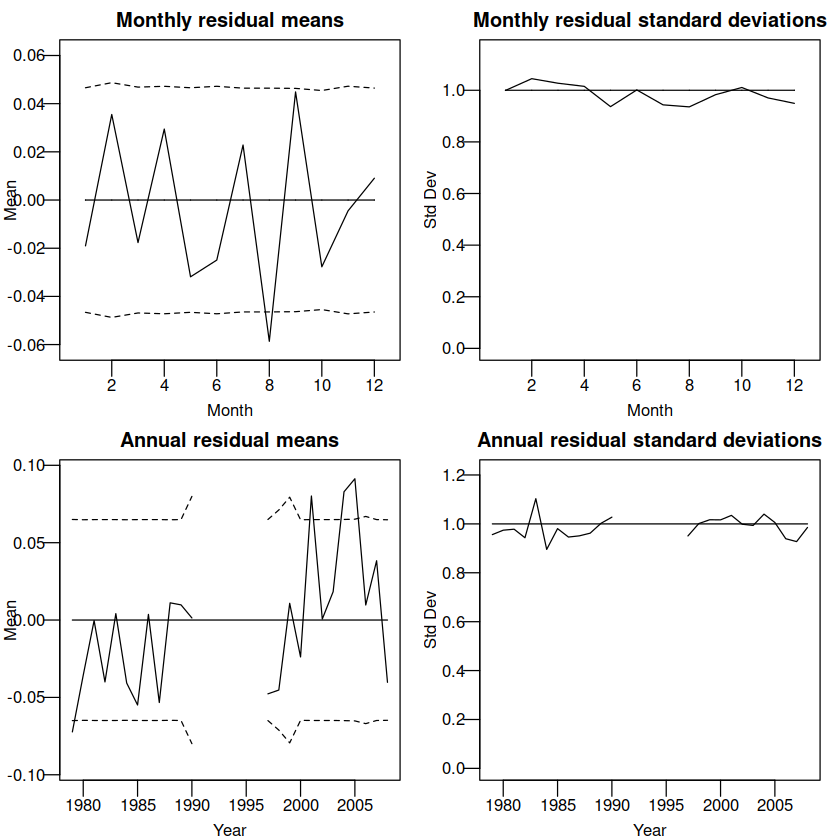

In [74]:
par(mfrow=c(2,2), mar=c(3,3,2,1), mgp=c(2,0.75,0))
plot(FittedModels$Fold3$Model5f, which.plots=1:2)

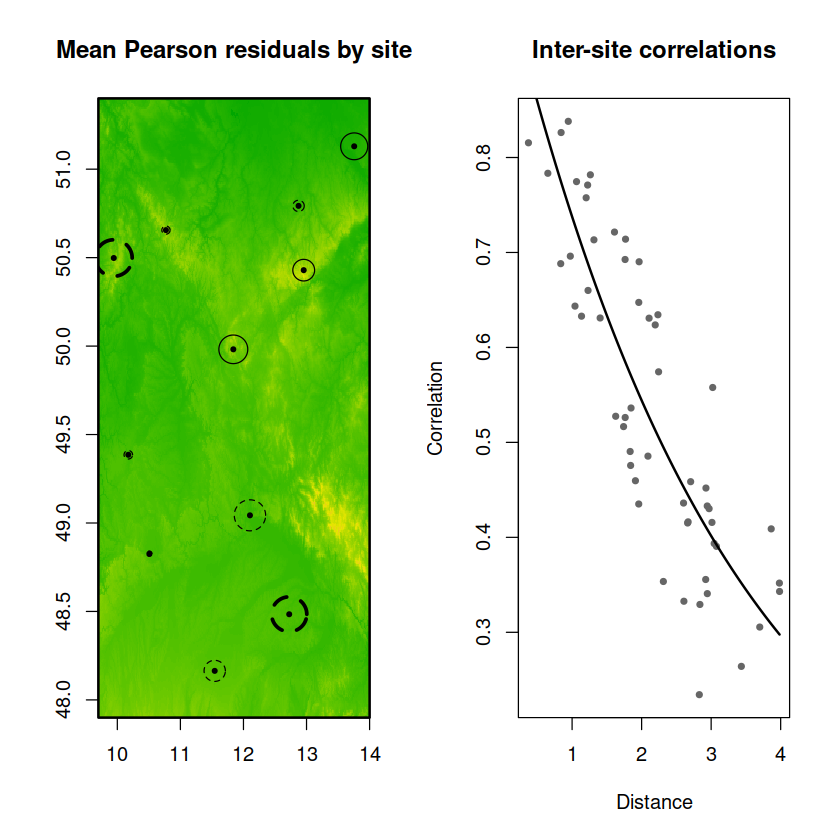

In [75]:
par(mfrow=c(1,2))
DrawMap(LongLims,LatLims)
plot(FittedModels$Fold3$Model5f,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=1))
plot(FittedModels$Fold3$Model5f, which.plots=5)

That will do: again there's some temperature-induced time trend in the residuals but it's hard to see what to do about it. 


In [76]:
FinalModels$Fold3 <- FittedModels$Fold3$Model5f


### Finalising model for Fold 4

Look for candidate interactions to delete from Model 5a. Have to go down to a $p$-value threshold of 0.005 to get anything that isn't a $u$-wind component, but this is probably OK. 


In [77]:
print(FittedModels$Fold4$Model5a)

MODEL 5A

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.7072   0.5513 -23.0503 < 2.2e-16
1                       MappedAltitude      0.1075   0.0043  24.7231 < 2.2e-16
2                   E-W_slope_1000km^2      2.1780   0.3193   6.8201 9.096e-12
3                    N-S_slope_100km^2      0.3694   0.0999   3.6959 0.0002191
4  Daily annual cycle, cosine componen     -3.3388   0.7012  -4.7616 1.920e-06
5   Daily annual cycle, sine component     -0.8306   0.7180  -1.1567 0.2473800
6  First harmonic of daily annual cycl      0.0956   0.0430   2.2223 0.0262630
7  First harmonic of daily annual cycl      0.2308   0.0467   4.9423 7.722e-07
8  Second harmonic of daily annual cyc     -0.0309   0.0260  -1.1879 0.2348682
9  Second harmonic of daily annual cyc     -0.0543   0.0259  -2.0927 0.0363720
10 Distance-weighted mean of I(Precip[      0.1425   0.0493   2.8

In [78]:
FindCandidateDeletions(FittedModels$Fold4$Model5a, 0.005)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   500-hPa wind speed (m/s)
   700-hPa wind speed (m/s)

Remove seasonal interactions with 500hPa and 700hPa wind speed, and check. 


In [79]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5bFold4Init.def")) {
  write.modeldef(FittedModels$Fold4$Model5a, 
                 "Rglimclim_files/DEFINITIONS/Model5bFold4Init.def")
}
Model5b.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5bFold4Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
YearsToExclude <- Folds$First[4]:Folds$Last[4]
write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
              file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
FittedModels$Fold4$Model5b <- 
  GLCfit(Model5b.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold4$Model5a, FittedModels$Fold4$Model5b))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 4 - MODEL 5B

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          94694         -45859.46                                        
M1 vs M2    94698       4 -45943.14 83.684 < 2.22e-16     19.771 5.3821e-08


Check changes in predicted probabilities:


In [80]:
print(summary(FittedModels$Fold4$Model5a, tables=NULL))
print(summary(FittedModels$Fold4$Model5b, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 94754 observations

# of parameters estimated: 60          Independence log-likelihood: -45859.46
Residual degrees of freedom: 94694     Deviance: 91718.91            
Mean squared error (mean Brier score): 0.1614


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0078 (std err 0.0067), standard deviation 0.9826

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.035 0.148 0.263 0.362 0.472 0.556 0.643 0.729 0.819 0.935
Expected prop.  0.047 0.148 0.249 0.349 0.449 0.549 0.649 0.749 0.847 0.932
Number of cases 19906 14210 11795 10043  9092  8248  7683  6769  5052  1956
NULL
FOLD 4 - MODEL 5B

Response variable: Precip 

Model of type 'logistic', fitted to 94754 observations

# of parameters estimated: 56          Ind

Nothing to worry about there. Check other candidate interactions for deletion, using $p$-value threshold of 0.01:


In [81]:
FindCandidateDeletions(FittedModels$Fold4$Model5b, 0.01)

Seasonal interactions to drop are with:
   850-hPa wind speed (m/s)

850hPa wind speed interaction can go now (just copy the initial definition file for Model 5b and delete the relevant rows).


In [82]:
Model5c.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5cFold4Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold4$Model5c <- 
  GLCfit(Model5c.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold4$Model5a, FittedModels$Fold4$Model5c))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 4 - MODEL 5C

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          94694         -45859.46                                        
M1 vs M2    94700       6 -45948.13 88.671 < 2.22e-16      20.89 2.0328e-07


In [83]:
print(summary(FittedModels$Fold4$Model5a, tables=NULL))
print(summary(FittedModels$Fold4$Model5c, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 94754 observations

# of parameters estimated: 60          Independence log-likelihood: -45859.46
Residual degrees of freedom: 94694     Deviance: 91718.91            
Mean squared error (mean Brier score): 0.1614


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0078 (std err 0.0067), standard deviation 0.9826

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.035 0.148 0.263 0.362 0.472 0.556 0.643 0.729 0.819 0.935
Expected prop.  0.047 0.148 0.249 0.349 0.449 0.549 0.649 0.749 0.847 0.932
Number of cases 19906 14210 11795 10043  9092  8248  7683  6769  5052  1956
NULL
FOLD 4 - MODEL 5C

Response variable: Precip 

Model of type 'logistic', fitted to 94754 observations

# of parameters estimated: 54          Ind

In [84]:
FindCandidateDeletions(FittedModels$Fold4$Model5c, 0.01)

Seasonal interactions to drop are with:
   850-hPa u wind (m/s)


Still little change in probabilistic calibration, and no further change in Brier score. No further interactions to remove, so look for anything else e.g. main effects. 


In [85]:
print(FittedModels$Fold4$Model5c)

FOLD 4 - MODEL 5C

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.8679   0.5506 -23.3687 < 2.2e-16
1                       MappedAltitude      0.1077   0.0043  24.7996 < 2.2e-16
2                   E-W_slope_1000km^2      2.1808   0.3186   6.8456 7.616e-12
3                    N-S_slope_100km^2      0.3698   0.0997   3.7094 0.0002078
4  Daily annual cycle, cosine componen     -3.3097   0.7028  -4.7093 2.486e-06
5   Daily annual cycle, sine component     -0.7658   0.7161  -1.0694 0.2848954
6  First harmonic of daily annual cycl      0.0894   0.0427   2.0944 0.0362282
7  First harmonic of daily annual cycl      0.2175   0.0466   4.6694 3.020e-06
8  Second harmonic of daily annual cyc     -0.0265   0.0260  -1.0170 0.3091593
9  Second harmonic of daily annual cyc     -0.0509   0.0260  -1.9579 0.0502446
10 Distance-weighted mean of I(Precip[      0.1418   0.0

Wind speed main effects can probably go. Again, just copy the existing definition file and remove them. 


In [86]:
Model5d.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5dFold4Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold4$Model5d <- 
  GLCfit(Model5d.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold4$Model5a, FittedModels$Fold4$Model5d))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 4 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          94694         -45859.46                                         
M1 vs M2    94703       9 -46029.14 169.686 < 2.22e-16     39.616 2.2961e-13


In [87]:
FindCandidateDeletions(FittedModels$Fold4$Model5d, 0.01)

Seasonal interactions to drop are with:
   850-hPa u wind (m/s)

In [88]:
print(summary(FittedModels$Fold4$Model5a, tables=NULL))
print(summary(FittedModels$Fold4$Model5d, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 94754 observations

# of parameters estimated: 60          Independence log-likelihood: -45859.46
Residual degrees of freedom: 94694     Deviance: 91718.91            
Mean squared error (mean Brier score): 0.1614


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0078 (std err 0.0067), standard deviation 0.9826

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.035 0.148 0.263 0.362 0.472 0.556 0.643 0.729 0.819 0.935
Expected prop.  0.047 0.148 0.249 0.349 0.449 0.549 0.649 0.749 0.847 0.932
Number of cases 19906 14210 11795 10043  9092  8248  7683  6769  5052  1956
NULL
FOLD 4 - MODEL 5D

Response variable: Precip 

Model of type 'logistic', fitted to 94754 observations

# of parameters estimated: 51          Ind

It's a bit worse, but I can live with it. 


In [89]:
print(FittedModels$Fold4$Model5d)

FOLD 4 - MODEL 5D

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.8924   0.5541 -23.2687 < 2.2e-16
1                       MappedAltitude      0.1063   0.0043  24.4493 < 2.2e-16
2                   E-W_slope_1000km^2      2.1417   0.3185   6.7240 1.768e-11
3                    N-S_slope_100km^2      0.3640   0.0996   3.6555 0.0002567
4  Daily annual cycle, cosine componen     -3.4031   0.7057  -4.8226 1.417e-06
5   Daily annual cycle, sine component     -0.6996   0.7215  -0.9695 0.3322841
6  First harmonic of daily annual cycl      0.0888   0.0427   2.0799 0.0375357
7  First harmonic of daily annual cycl      0.2248   0.0465   4.8403 1.296e-06
8  Second harmonic of daily annual cyc     -0.0298   0.0261  -1.1424 0.2532918
9  Second harmonic of daily annual cyc     -0.0524   0.0260  -2.0165 0.0437438
10 Distance-weighted mean of I(Precip[      0.1538   0.0

Next, add external: regional and lag interactions.

In [90]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5eFold4Init.def")) {
  write.modeldef(FittedModels$Fold4$Model5d, 
                 "Rglimclim_files/DEFINITIONS/Model5eFold4Init.def")
}
Model5e.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5eFold4Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold4$Model5e <- 
  GLCfit(Model5e.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold4$Model5d, FittedModels$Fold4$Model5e))

Comparison of nested models
---------------------------

Model 1: FOLD 4 - MODEL 5E 
Model 2: FOLD 4 - MODEL 5D

         Resid DF DF2-DF1      LogL      LLR          p Robust LLR   Robust p
M1          94663         -44989.98                                          
M1 vs M2    94703      40 -46029.14 1039.166 < 2.22e-16    220.811 < 2.22e-16


In [91]:
print(FittedModels$Fold4$Model5e)

FOLD 4 - MODEL 5E

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.2699   0.8089 -15.1687 < 2.2e-16
1                       MappedAltitude      0.0083   0.0812   0.1024 0.9184574
2                   E-W_slope_1000km^2      7.6942   7.8926   0.9749 0.3296287
3                    N-S_slope_100km^2      1.6295   2.3835   0.6837 0.4941915
4  Daily annual cycle, cosine componen     -4.5546   0.7492  -6.0789 1.210e-09
5   Daily annual cycle, sine component     -0.7073   0.7316  -0.9668 0.3336292
6  First harmonic of daily annual cycl      0.0897   0.0436   2.0558 0.0398015
7  First harmonic of daily annual cycl      0.2521   0.0467   5.3984 6.725e-08
8  Second harmonic of daily annual cyc     -0.0298   0.0263  -1.1354 0.2562180
9  Second harmonic of daily annual cyc     -0.0578   0.0262  -2.2023 0.0276430
10 Distance-weighted mean of I(Precip[     -5.1978   1.4

Prune back the additional interactions using a $p$-value threshold of 0.001.

In [92]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5fFold4Init.def")) {
  write.modeldef(FittedModels$Fold4$Model5e, 
                 "Rglimclim_files/DEFINITIONS/Model5fFold4Init.def")
}
Model5f.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5fFold4Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold4$Model5f <- 
  GLCfit(Model5f.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold4$Model5e, FittedModels$Fold4$Model5f, 
            FittedModels$Fold4$Model5d))

Comparison of nested models
---------------------------

Model 1: FOLD 4 - MODEL 5E 
Model 2: FOLD 4 - MODEL 5F 
Model 3: FOLD 4 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          94663         -44989.98                                         
M1 vs M2    94682      19 -45094.10 104.121 < 2.22e-16     42.018 3.7117e-10
M2 vs M3    94703      21 -46029.14 935.045 < 2.22e-16    178.793 < 2.22e-16


Probably OK. Look for more terms to remove: 


In [93]:
print(FittedModels$Fold4$Model5f)

FOLD 4 - MODEL 5F

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.7112   0.5970 -22.9683 < 2.2e-16
1                       MappedAltitude      0.0967   0.0060  16.2447 < 2.2e-16
2                   E-W_slope_1000km^2     -0.5758   0.4708  -1.2230  0.221331
3                    N-S_slope_100km^2      0.0871   0.1533   0.5682  0.569913
4  Daily annual cycle, cosine componen     -4.5055   0.7454  -6.0446 1.498e-09
5   Daily annual cycle, sine component     -0.7517   0.7478  -1.0052  0.314785
6  First harmonic of daily annual cycl      0.0951   0.0434   2.1892  0.028581
7  First harmonic of daily annual cycl      0.2432   0.0470   5.1760 2.267e-07
8  Second harmonic of daily annual cyc     -0.0338   0.0262  -1.2899  0.197101
9  Second harmonic of daily annual cyc     -0.0583   0.0263  -2.2182  0.026540
10 Distance-weighted mean of I(Precip[     -0.1966   0.2

Get rid of seasonality:topography interactions and replace the spatial correlation structure with something more realistic. 

In [94]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5gFold4Init.def")) {
  write.modeldef(FittedModels$Fold4$Model5f, 
                 "Rglimclim_files/DEFINITIONS/Model5gFold4Init.def")
}
Model5g.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5gFold4Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold4$Model5g <- 
  GLCfit(Model5g.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"),
         cor.file="Rglimclim_files/Fold4Corr.dat", )
print(anova(FittedModels$Fold4$Model5f, FittedModels$Fold4$Model5g))

Comparison of nested models
---------------------------

Model 1: FOLD 4 - MODEL 5F 
Model 2: FOLD 4 - MODEL 5G

         Resid DF DF2-DF1      LogL   LLR          p Robust LLR   Robust p
M1          94682         -45094.10                                       
M1 vs M2    94688       6 -45101.42 7.321 0.02323309     11.413 0.00085676


In [95]:
print(summary(FittedModels$Fold4$Model5g, tables=NULL))
print(FittedModels$Fold4$Model5g)

FOLD 4 - MODEL 5G

Response variable: Precip 

Model of type 'logistic', fitted to 94754 observations

# of parameters estimated: 66          Independence log-likelihood: -45101.42
Residual degrees of freedom: 94688     Deviance: 90202.84            
Mean squared error (mean Brier score): 0.1584


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0038 (std err 0.0067), standard deviation 0.9853

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.040 0.149 0.251 0.358 0.466 0.548 0.642 0.740 0.830 0.947
Expected prop.  0.044 0.148 0.249 0.350 0.450 0.550 0.649 0.748 0.846 0.938
Number of cases 21539 13179 10687  9783  9328  8356  7956  6763  4809  2354
NULL
FOLD 4 - MODEL 5G

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err  

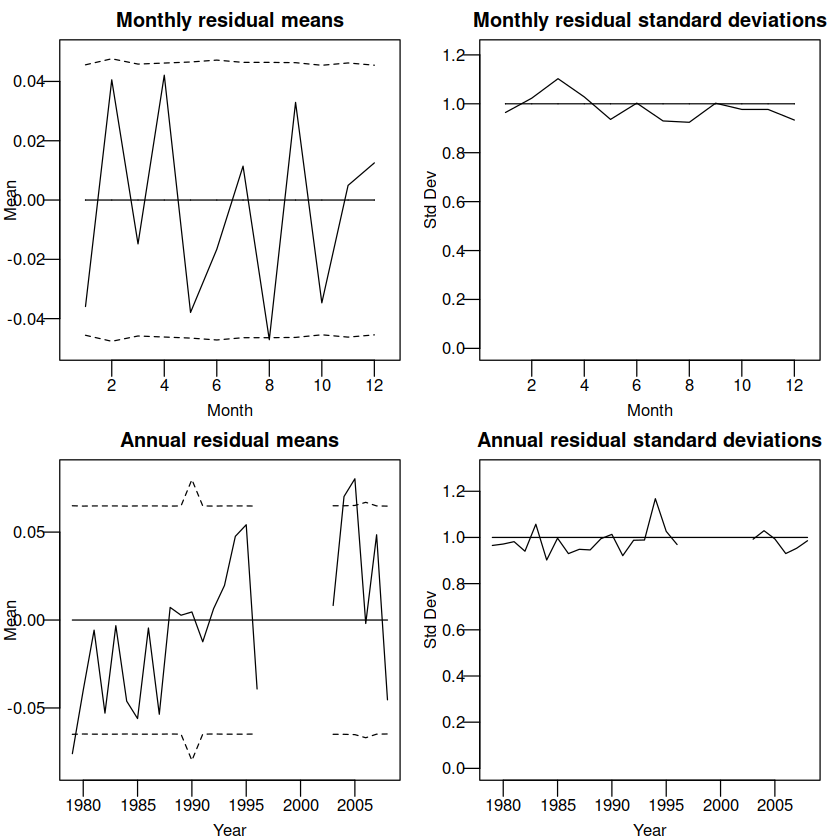

In [96]:
#
#   Let's do residual plots now, and think about inter-site correlation
#
par(mfrow=c(2,2), mar=c(3,3,2,1), mgp=c(2,0.75,0))
plot(FittedModels$Fold4$Model5g, which.plots=1:2)

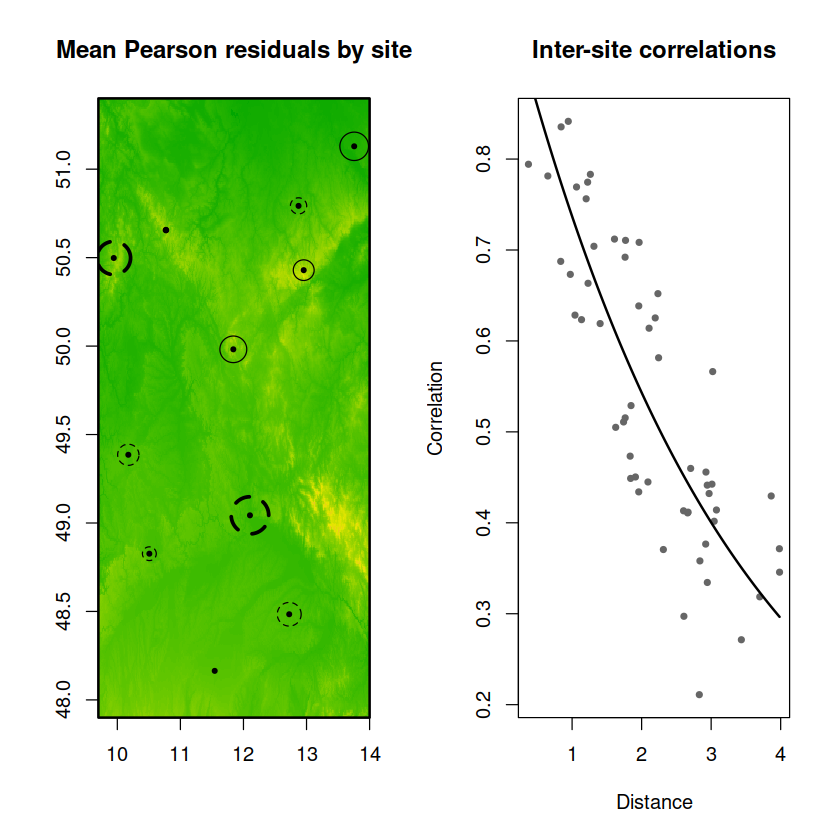

In [97]:
par(mfrow=c(1,2))
DrawMap(LongLims,LatLims)
plot(FittedModels$Fold4$Model5g,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=1))
plot(FittedModels$Fold4$Model5g, which.plots=5)

All good again. 


In [98]:
FinalModels$Fold4 <- FittedModels$Fold4$Model5g


### Finalising model for Fold 5

Look for candidate interactions to delete from Model 5a. Back to a $p$-value threshold of 0.05. 

In [99]:
print(FittedModels$Fold5$Model5a)

MODEL 5A

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.0610   0.5700 -22.9132 < 2.2e-16
1                       MappedAltitude      0.1124   0.0044  25.6165 < 2.2e-16
2                   E-W_slope_1000km^2      1.8398   0.3177   5.7904 7.023e-09
3                    N-S_slope_100km^2      0.5798   0.1006   5.7636 8.235e-09
4  Daily annual cycle, cosine componen     -2.5533   0.7170  -3.5609 0.0003695
5   Daily annual cycle, sine component     -1.5695   0.7348  -2.1359 0.0326906
6  First harmonic of daily annual cycl      0.1022   0.0427   2.3931 0.0167059
7  First harmonic of daily annual cycl      0.1796   0.0475   3.7803 0.0001567
8  Second harmonic of daily annual cyc     -0.0597   0.0263  -2.2717 0.0231069
9  Second harmonic of daily annual cyc     -0.0612   0.0260  -2.3587 0.0183397
10 Distance-weighted mean of I(Precip[      0.2671   0.0570   4.6

In [100]:
FindCandidateDeletions(FittedModels$Fold5$Model5a, 0.05)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   500-hPa wind speed (m/s)
   700-hPa wind speed (m/s)

Remove seasonal interactions with 500hPa and 700hPa wind speed, and check. 

In [101]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5bFold5Init.def")) {
  write.modeldef(FittedModels$Fold5$Model5a, 
                 "Rglimclim_files/DEFINITIONS/Model5bFold5Init.def")
}
Model5b.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5bFold5Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
YearsToExclude <- Folds$First[5]:Folds$Last[5]
write.GLCdata(PrecipData[!(PrecipData$Year %in% YearsToExclude),],
              file="Rglimclim_files/CurrentData.dat", check.file = FALSE)
FittedModels$Fold5$Model5b <- 
  GLCfit(Model5b.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold5$Model5a, FittedModels$Fold5$Model5b))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 5 - MODEL 5B

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          92989         -45556.40                                        
M1 vs M2    92993       4 -45602.24 45.838 < 2.22e-16     11.142 0.00017591


Check changes in predicted probabilities & Brier score: 

In [102]:
print(summary(FittedModels$Fold5$Model5a, tables=NULL))
print(summary(FittedModels$Fold5$Model5b, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 93049 observations

# of parameters estimated: 60          Independence log-likelihood: -45556.4
Residual degrees of freedom: 92989     Deviance: 91112.8             
Mean squared error (mean Brier score): 0.1633


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0063 (std err 0.0068), standard deviation 0.9889

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.039 0.144 0.262 0.364 0.470 0.547 0.648 0.733 0.826 0.927
Expected prop.  0.049 0.148 0.249 0.349 0.450 0.549 0.650 0.748 0.847 0.931
Number of cases 18620 13916 11592 10042  9081  8296  7740  6734  5096  1932
NULL
FOLD 5 - MODEL 5B

Response variable: Precip 

Model of type 'logistic', fitted to 93049 observations

# of parameters estimated: 56          Inde

Very little change. Check other candidate interactions for deletion, using $p$-value threshold of 0.01:

In [103]:
FindCandidateDeletions(FittedModels$Fold5$Model5b, 0.01)

Seasonal interactions to drop are with:
   MSLP (mbar-1000)
   850-hPa geopotential (units unclear)
   500-hPa u wind (m/s)
   850-hPa u wind (m/s)
   850-hPa wind speed (m/s)

850hPa wind speed interaction can go now, as well as MSLP and 850-hPa geopotential. The latter two are very similar in nature, so I'm just going to remove one of them for the moment. 

In [104]:
Model5c.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5cFold5Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold5$Model5c <- 
  GLCfit(Model5c.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold5$Model5a, FittedModels$Fold5$Model5c))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 5 - MODEL 5C

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          92989         -45556.40                                        
M1 vs M2    92997       8 -45611.96 55.562 < 2.22e-16     13.416 0.00075582


In [105]:
print(summary(FittedModels$Fold5$Model5a, tables=NULL))
print(summary(FittedModels$Fold5$Model5c, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 93049 observations

# of parameters estimated: 60          Independence log-likelihood: -45556.4
Residual degrees of freedom: 92989     Deviance: 91112.8             
Mean squared error (mean Brier score): 0.1633


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0063 (std err 0.0068), standard deviation 0.9889

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.039 0.144 0.262 0.364 0.470 0.547 0.648 0.733 0.826 0.927
Expected prop.  0.049 0.148 0.249 0.349 0.450 0.549 0.650 0.748 0.847 0.931
Number of cases 18620 13916 11592 10042  9081  8296  7740  6734  5096  1932
NULL
FOLD 5 - MODEL 5C

Response variable: Precip 

Model of type 'logistic', fitted to 93049 observations

# of parameters estimated: 52          Inde

In [106]:
FindCandidateDeletions(FittedModels$Fold5$Model5c, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   850-hPa u wind (m/s)

No further interactions to remove, so look for anything else e.g. main effects. 

In [107]:
print(FittedModels$Fold5$Model5c)

FOLD 5 - MODEL 5C

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.3237   0.5639 -23.6268 < 2.2e-16
1                       MappedAltitude      0.1125   0.0044  25.7192 < 2.2e-16
2                   E-W_slope_1000km^2      1.8427   0.3176   5.8016 6.570e-09
3                    N-S_slope_100km^2      0.5798   0.1004   5.7738 7.751e-09
4  Daily annual cycle, cosine componen     -1.1584   0.2288  -5.0630 4.127e-07
5   Daily annual cycle, sine component     -1.3187   0.2246  -5.8715 4.318e-09
6  First harmonic of daily annual cycl      0.1203   0.0400   3.0054  0.002652
7  First harmonic of daily annual cycl      0.1803   0.0438   4.1137 3.894e-05
8  Second harmonic of daily annual cyc     -0.0466   0.0255  -1.8271  0.067687
9  Second harmonic of daily annual cyc     -0.0525   0.0255  -2.0563  0.039751
10 Distance-weighted mean of I(Precip[      0.2515   0.0

Wind speed main effects can probably go. Again, just copy the existing definition file and remove them. 

In [108]:
Model5d.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5dFold5Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold5$Model5d <- 
  GLCfit(Model5d.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold5$Model5a, FittedModels$Fold5$Model5d))

Comparison of nested models
---------------------------

Model 1: MODEL 5A 
Model 2: FOLD 5 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          92989         -45556.40                                         
M1 vs M2    93000      11 -45692.37 135.965 < 2.22e-16     33.466 4.6588e-10


In [109]:
FindCandidateDeletions(FittedModels$Fold5$Model5d, 0.01)

Seasonal interactions to drop are with:
   500-hPa u wind (m/s)
   850-hPa u wind (m/s)

In [110]:
print(summary(FittedModels$Fold5$Model5a, tables=NULL))
print(summary(FittedModels$Fold5$Model5d, tables=NULL))

MODEL 5A

Response variable: Precip 

Model of type 'logistic', fitted to 93049 observations

# of parameters estimated: 60          Independence log-likelihood: -45556.4
Residual degrees of freedom: 92989     Deviance: 91112.8             
Mean squared error (mean Brier score): 0.1633


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0063 (std err 0.0068), standard deviation 0.9889

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.039 0.144 0.262 0.364 0.470 0.547 0.648 0.733 0.826 0.927
Expected prop.  0.049 0.148 0.249 0.349 0.450 0.549 0.650 0.748 0.847 0.931
Number of cases 18620 13916 11592 10042  9081  8296  7740  6734  5096  1932
NULL
FOLD 5 - MODEL 5D

Response variable: Precip 

Model of type 'logistic', fitted to 93049 observations

# of parameters estimated: 49          Inde

As usual: it's a bit worse, but I can live with it (focus on Brier score in particular).

In [111]:
print(FittedModels$Fold5$Model5d)

FOLD 5 - MODEL 5D

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -13.3445   0.5677 -23.5081 < 2.2e-16
1                       MappedAltitude      0.1111   0.0044  25.3367 < 2.2e-16
2                   E-W_slope_1000km^2      1.8129   0.3166   5.7257 1.030e-08
3                    N-S_slope_100km^2      0.5731   0.1003   5.7157 1.093e-08
4  Daily annual cycle, cosine componen     -1.2515   0.2264  -5.5280 3.239e-08
5   Daily annual cycle, sine component     -1.3364   0.2245  -5.9537 2.621e-09
6  First harmonic of daily annual cycl      0.1152   0.0400   2.8808  0.003967
7  First harmonic of daily annual cycl      0.1857   0.0438   4.2373 2.262e-05
8  Second harmonic of daily annual cyc     -0.0508   0.0255  -1.9909  0.046487
9  Second harmonic of daily annual cyc     -0.0566   0.0255  -2.2173  0.026600
10 Distance-weighted mean of I(Precip[      0.2659   0.0

Next, add external: regional and lag interactions.

In [112]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5eFold5Init.def")) {
  write.modeldef(FittedModels$Fold5$Model5d, 
                 "Rglimclim_files/DEFINITIONS/Model5eFold5Init.def")
}
Model5e.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5eFold5Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold5$Model5e <- 
  GLCfit(Model5e.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold5$Model5d, FittedModels$Fold5$Model5e))

Comparison of nested models
---------------------------

Model 1: FOLD 5 - MODEL 5D 
Model 2: FOLD 5 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          92960         -44773.63                                         
M1 vs M2    93000      40 -45692.37 918.736 < 2.22e-16    364.789 < 2.22e-16


In [113]:
print(FittedModels$Fold5$Model5e)

FOLD 5 - MODEL 5D

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -11.9875   0.8246 -14.5372 < 2.2e-16
1                       MappedAltitude     -0.0438   0.0835  -0.5238  0.600448
2                   E-W_slope_1000km^2      5.2588   8.0754   0.6512  0.514913
3                    N-S_slope_100km^2      1.8480   2.5223   0.7327  0.463750
4  Daily annual cycle, cosine componen     -1.1738   0.2375  -4.9428 7.700e-07
5   Daily annual cycle, sine component     -1.2878   0.2249  -5.7273 1.020e-08
6  First harmonic of daily annual cycl      0.1322   0.0408   3.2430  0.001183
7  First harmonic of daily annual cycl      0.2184   0.0439   4.9792 6.386e-07
8  Second harmonic of daily annual cyc     -0.0422   0.0257  -1.6427  0.100446
9  Second harmonic of daily annual cyc     -0.0478   0.0258  -1.8497  0.064356
10 Distance-weighted mean of I(Precip[     -6.9980   1.5

Prune back the additional interactions using a $p$-value threshold of 0.001.

In [114]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5fFold5Init.def")) {
  write.modeldef(FittedModels$Fold5$Model5e, 
                 "Rglimclim_files/DEFINITIONS/Model5fFold5Init.def")
}
Model5f.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5fFold5Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold5$Model5f <- 
  GLCfit(Model5f.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
print(anova(FittedModels$Fold5$Model5e, FittedModels$Fold5$Model5f, 
            FittedModels$Fold5$Model5d))

Comparison of nested models
---------------------------

Model 1: FOLD 5 - MODEL 5D 
Model 2: FOLD 5 - MODEL 5F 
Model 3: FOLD 5 - MODEL 5D

         Resid DF DF2-DF1      LogL     LLR          p Robust LLR   Robust p
M1          92960         -44773.63                                         
M1 vs M2    92978      18 -44820.76  47.131 2.4593e-12     32.799 2.4734e-07
M2 vs M3    93000      22 -45692.37 871.604 < 2.22e-16     331.99 < 2.22e-16


Not bad. Look for more terms to remove: 

In [115]:
print(FittedModels$Fold5$Model5f)

FOLD 5 - MODEL 5F

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.5608   0.6645 -18.9023 < 2.2e-16
1                       MappedAltitude      0.0985   0.0059  16.6755 < 2.2e-16
2                   E-W_slope_1000km^2     -0.9389   0.4769  -1.9689 0.0489698
3                    N-S_slope_100km^2      0.3049   0.1538   1.9833 0.0473346
4  Daily annual cycle, cosine componen     -1.1452   0.2358  -4.8559 1.199e-06
5   Daily annual cycle, sine component     -1.3399   0.2236  -5.9923 2.069e-09
6  First harmonic of daily annual cycl      0.1360   0.0407   3.3427 0.0008296
7  First harmonic of daily annual cycl      0.2173   0.0439   4.9535 7.290e-07
8  Second harmonic of daily annual cyc     -0.0440   0.0257  -1.7146 0.0864118
9  Second harmonic of daily annual cyc     -0.0477   0.0258  -1.8471 0.0647315
10 Distance-weighted mean of I(Precip[     -7.5975   1.4

Get rid of seasonality:topography interactions and replace the spatial correlation structure with something more realistic. 


In [116]:
if (!file.exists("Rglimclim_files/DEFINITIONS/Model5gFold5Init.def")) {
  write.modeldef(FittedModels$Fold5$Model5f, 
                 "Rglimclim_files/DEFINITIONS/Model5gFold5Init.def")
}
Model5g.Init <- 
  read.modeldef("Rglimclim_files/DEFINITIONS/Model5gFold5Init.def", model.type = "logistic",
                siteinfo=stations, var.names = "Precip",
                oldGlimClim.warning=FALSE,
                external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"))
FittedModels$Fold5$Model5g <- 
  GLCfit(Model5g.Init, data.file="Rglimclim_files/CurrentData.dat", siteinfo=stations,
         model.type="logistic", diagnostics=1, nprev.required=1,
         verbosity=0, external.files = c("","","Rglimclim_files/DailyPreds_Averaged.dat"),
         cor.file="Rglimclim_files/Fold5Corr.dat", )
print(anova(FittedModels$Fold5$Model5f, FittedModels$Fold5$Model5g))

Comparison of nested models
---------------------------

Model 1: FOLD 5 - MODEL 5F 
Model 2: FOLD 5 - MODEL 5G

         Resid DF DF2-DF1      LogL    LLR          p Robust LLR   Robust p
M1          92978         -44820.76                                        
M1 vs M2    92984       6 -44833.03 12.271 0.00041509     19.593 6.5793e-07


In [117]:
print(summary(FittedModels$Fold5$Model5g, tables=NULL))

FOLD 5 - MODEL 5G

Response variable: Precip 

Model of type 'logistic', fitted to 93049 observations

# of parameters estimated: 65          Independence log-likelihood: -44833.03
Residual degrees of freedom: 92984     Deviance: 89666.07            
Mean squared error (mean Brier score): 0.1605


No dispersion parameters estimated for this model

Pearson residuals: mean -0.0047 (std err 0.0067), standard deviation 0.9843

Occurrence frequencies vs forecasts:
------------------------------------
                                      Forecast decile
                    1     2     3     4     5     6     7     8     9    10
Observed prop.  0.041 0.147 0.256 0.363 0.462 0.544 0.648 0.734 0.831 0.945
Expected prop.  0.047 0.147 0.249 0.350 0.449 0.549 0.649 0.748 0.846 0.937
Number of cases 20011 13263 10854  9557  9046  8334  7869  6800  4952  2363
NULL


In [118]:
print(FittedModels$Fold5$Model5g)

FOLD 5 - MODEL 5G

Response variable: Precip 

Main effects:
-------------
                                       Coefficient  Std Err   Z-stat Pr(|Z|>z)
                              Constant    -12.5856   0.6644 -18.9415 < 2.2e-16
1                       MappedAltitude      0.1000   0.0059  16.9898 < 2.2e-16
2                   E-W_slope_1000km^2     -0.9062   0.4755  -1.9059 0.0566642
3                    N-S_slope_100km^2      0.2943   0.1533   1.9197 0.0548996
4  Daily annual cycle, cosine componen     -1.2653   0.2318  -5.4578 4.820e-08
5   Daily annual cycle, sine component     -1.3978   0.2211  -6.3208 2.603e-10
6  First harmonic of daily annual cycl      0.1366   0.0406   3.3623 0.0007729
7  First harmonic of daily annual cycl      0.2177   0.0439   4.9635 6.925e-07
8  Second harmonic of daily annual cyc     -0.0440   0.0257  -1.7158 0.0862067
9  Second harmonic of daily annual cyc     -0.0480   0.0258  -1.8587 0.0630730
10 Distance-weighted mean of I(Precip[     -7.6273   1.4

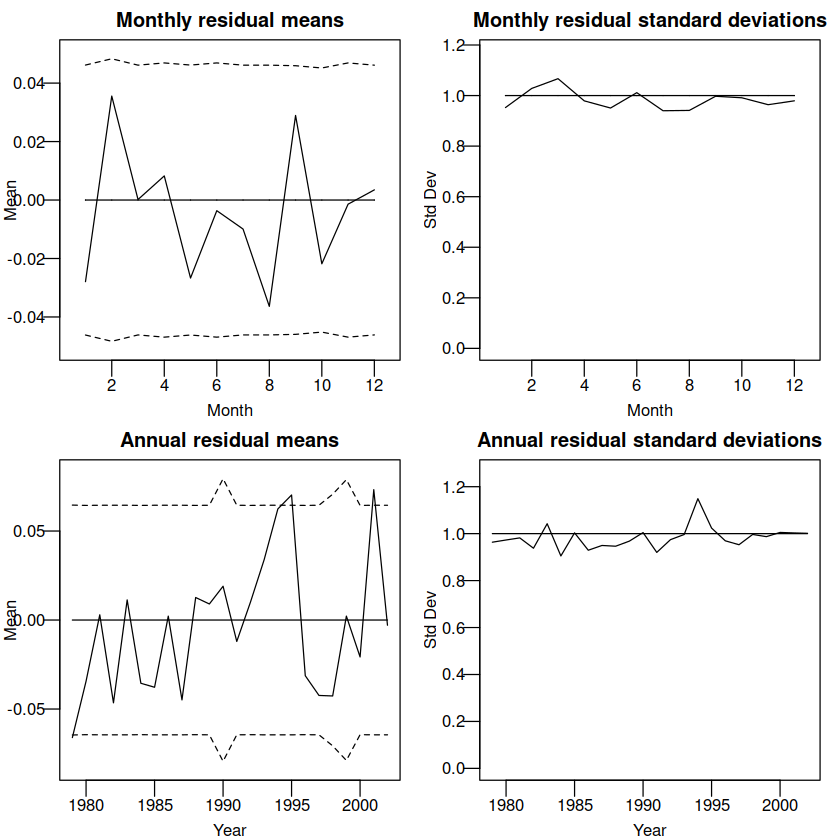

In [119]:
#
#   Let's do residual plots now, and think about inter-site correlation
#
par(mfrow=c(2,2), mar=c(3,3,2,1), mgp=c(2,0.75,0))
plot(FittedModels$Fold5$Model5g, which.plots=1:2)

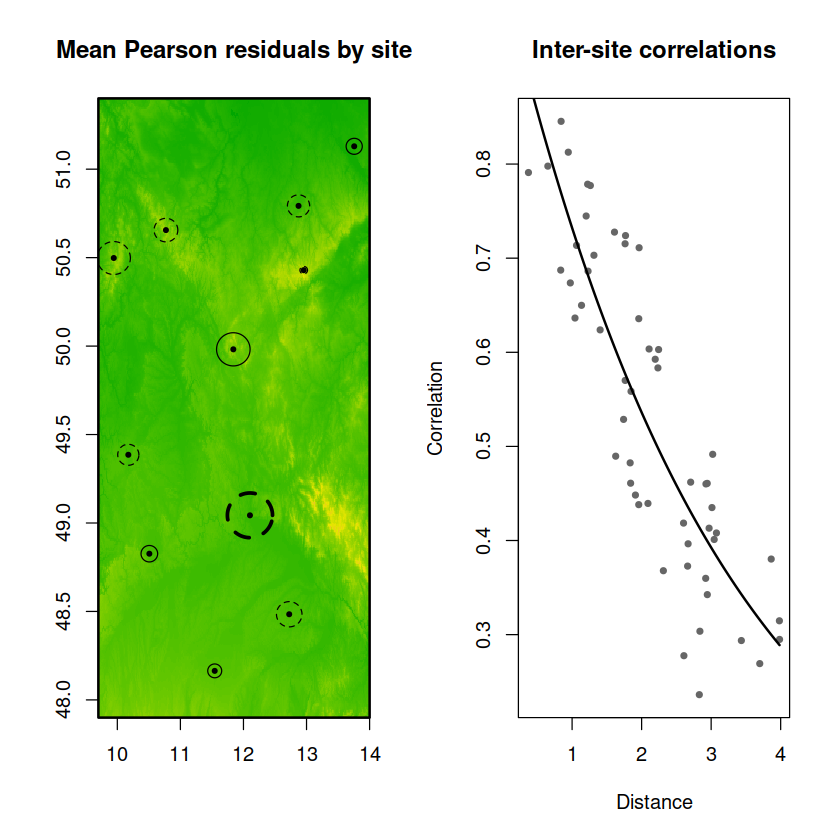

In [120]:
par(mfrow=c(1,2))
DrawMap(LongLims,LatLims)
plot(FittedModels$Fold5$Model5g,which.plots=3,
     site.options=list(add.to.map=TRUE,site.labels="none",scale=1))
plot(FittedModels$Fold5$Model5g, which.plots=5)

Could possibly remove the MSLP:seasonality interactions but they're not doing any harm so I'll finish there. 


In [121]:
FinalModels$Fold5 <- FittedModels$Fold5$Model5g
save(FinalModels, Folds, NFolds, file="Rglimclim_files/FinalModels.rda")

Remove some auxiliary files:

In [122]:
file.remove(list.files(path = "Rglimclim_files", pattern="def$", full.names = T))
file.remove(list.files(path = "Rglimclim_files", pattern="Corr.dat$", full.names = T))
file.remove(list.files(path =  "Rglimclim_files", pattern="Resids.dat$", full.names = T))

logical(0)

[1] TRUE TRUE TRUE TRUE TRUE

logical(0)